# Enhanced Ring Attractor Network Training
## Adam Optimizer with Cosine Annealing Learning Rate Schedule

This notebook demonstrates the enhanced training system for ring attractor networks, featuring:

- **Adam Optimizer**: Adaptive learning rate with momentum and RMSprop components
- **Cosine Annealing**: Smooth learning rate decay for better convergence
- **Biological Constraints**: Ensures parameters remain biologically plausible
- **Comprehensive Monitoring**: Track training progress, gradients, and network parameters
- **Interactive Visualization**: Real-time plots of training metrics

### Mathematical Background

**Adam Optimizer Updates:**
```
m_t = β₁ * m_{t-1} + (1 - β₁) * g_t          # Momentum
v_t = β₂ * v_{t-1} + (1 - β₂) * g_t²         # RMSprop
m̂_t = m_t / (1 - β₁^t)                       # Bias correction
v̂_t = v_t / (1 - β₂^t)                       # Bias correction
θ_t = θ_{t-1} - α * m̂_t / (√v̂_t + ε)         # Parameter update
```

**Cosine Annealing Learning Rate:**
```
η_t = η_min + (η_max - η_min) * (1 + cos(πt/T)) / 2
```

Where `T` is the total number of epochs and `t` is the current epoch.

In [ ]:
# Import necessary libraries and set up environment
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import os
import sys
warnings.filterwarnings('ignore')

# Add the src directory to Python path for importing modules
import pathlib
notebook_dir = pathlib.Path().absolute()
src_path = notebook_dir.parent / 'src'
sys.path.insert(0, str(src_path))

print(f"Added to Python path: {src_path}")

# Import your ring attractor modules
from models import RingAttractorNetwork
from enhanced_training import AdamCosineTrainer, create_training_config, train_ring_attractor_with_adam_cosine
from training import train_model  # Original training for comparison
from utils import generate_trajectory, angle_to_input, compute_error

print("Successfully imported all ring attractor modules")

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Use B200 GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

print(f"All modules imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"Current working directory: {os.getcwd()}")

In [2]:
# Test all imports to verify everything is working
print("Testing all imports...")

try:
    # Test basic PyTorch functionality
    import torch
    test_tensor = torch.randn(2, 3)
    print("PyTorch working")
    
    # Test ring attractor modules
    from models import RingAttractorNetwork
    print("RingAttractorNetwork imported")
    
    from enhanced_training import AdamCosineTrainer, create_training_config
    print("Enhanced training system imported")
    
    from training import train_model
    print("Original training imported")
    
    from utils import generate_trajectory, angle_to_input, compute_error
    print("Utilities imported")
    
    # Test creating a small model
    test_model = RingAttractorNetwork(n_exc=8, n_inh=2, dt=0.01)
    print("Model creation working")
    
    # Test utility functions
    test_angles, _ = generate_trajectory(10, dt=0.1)
    test_inputs = angle_to_input(test_angles)
    print("Utility functions working")
    
    print("\nAll imports and basic functionality tests passed!")
    
    
except ImportError as e:
    print(f"Import error: {e}")
    print("Please make sure you're running this notebook from the notebooks/ directory")
    
except Exception as e:
    print(f"Unexpected error: {e}")
    print("There might be an issue with the code - please check the error message above")

Testing all imports...
PyTorch working
RingAttractorNetwork imported
Enhanced training system imported
Original training imported
Utilities imported
Model creation working
Utility functions working

All imports and basic functionality tests passed!


In [3]:
# Create ring attractor network with standard parameters
"""
Initialize a ring attractor network for head direction cell modeling.
The network consists of excitatory and inhibitory populations arranged in a ring topology.
"""

# Network parameters
n_exc = 800        # Number of excitatory neurons (head direction cells)
n_inh = 200        # Number of inhibitory neurons
n_neurons = n_exc  # For backward compatibility with other cells
dt = 0.01          # Time step (seconds)
tau_e = 0.02       # Excitatory time constant
tau_i = 0.005      # Inhibitory time constant

# Create the model with proper device handling
model = RingAttractorNetwork(
    n_exc=n_exc,
    n_inh=n_inh,
    dt=dt,
    tau_e=tau_e,
    tau_i=tau_i,
    device=device
)

# Move model to device and reset state to ensure everything is on the correct device
model = model.to(device)
model.reset_state()

print("Ring Attractor Network Initialized")
print(f"Excitatory neurons: {n_exc}")
print(f"Inhibitory neurons: {n_inh}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Model device: {next(model.parameters()).device}")
print(f"State device: {model.r_e.device if hasattr(model, 'r_e') and model.r_e is not None else 'Not initialized'}")

# Display initial parameters
print("\nInitial Network Parameters")
print(f"g_ee (E→E gain): {model.g_ee.item():.3f}")
print(f"g_ei (E→I gain): {model.g_ei.item():.3f}") 
print(f"g_ie (I→E gain): {model.g_ie.item():.3f}")
print(f"noise_rate_e: {model.noise_rate_e.item():.3f}")
print(f"noise_rate_i: {model.noise_rate_i.item():.3f}")

# Display connectivity matrix shapes (now fixed!)
print(f"\nConnectivity matrices (corrected dimensions):")
print(f"W_EI shape: {model.W_EI.shape} (E→I weights, used as transpose)")
print(f"W_IE shape: {model.W_IE.shape} (I→E weights, used as transpose)")

# Test model forward pass to ensure device compatibility
print("\nDevice Compatibility Test")
test_input = torch.randn(n_exc, device=device) * 0.1
try:
    test_output = model(test_input)
    print(f"Forward pass successful")
    print(f"Input device: {test_input.device}")
    print(f"Output device: {test_output.device}")
    print(f"All tensors on same device: {test_input.device == test_output.device}")
    print(f"Matrix operations working correctly - network ready for training!")
except Exception as e:
    print(f"Device compatibility issue: {e}")
    raise


Ring Attractor Network Initialized
Excitatory neurons: 800
Inhibitory neurons: 200
Total parameters: 320007
Model device: cpu
State device: cpu

Initial Network Parameters
g_ee (E→E gain): 1.000
g_ei (E→I gain): 1.500
g_ie (I→E gain): 2.000
noise_rate_e: 0.100
noise_rate_i: 0.050

Connectivity matrices (corrected dimensions):
W_EI shape: torch.Size([800, 200]) (E→I weights, used as transpose)
W_IE shape: torch.Size([200, 800]) (I→E weights, used as transpose)

Device Compatibility Test
Forward pass successful
Input device: cpu
Output device: cpu
All tensors on same device: True
Matrix operations working correctly - network ready for training!


In [4]:

# Quick test to verify the fix works
"""
Test that the in-place operation error has been fixed.
This will run a minimal training example to confirm the gradient computation works.
"""

print("Testing the In-Place Operation Fix")

# Create a small test model
test_model = RingAttractorNetwork(
    n_exc=800,  # Small network for quick testing
    n_inh=200,
    dt=0.01,
    device=device
)

# Move to device and reset state
test_model = test_model.to(device)
test_model.reset_state()

# Create simple test data
test_input = torch.randn(800, device=device) * 0.1
test_target = torch.randn(800, device=device) * 0.1

print(f"✓ Test model created on device: {next(test_model.parameters()).device}")

# Test forward pass
try:
    output = test_model(test_input, steps=1)
    print(f"✓ Forward pass successful, output shape: {output.shape}")
except Exception as e:
    print(f"Forward pass failed: {e}")
    raise

# Test backward pass (this is where the error was occurring)
try:
    # Simple loss calculation
    loss = torch.nn.functional.mse_loss(output, test_target)
    print(f"✓ Loss calculation successful: {loss.item():.6f}")
    
    # Backward pass - this is where the in-place operation error was happening
    loss.backward()
    print("✓ Backward pass successful - gradient computation works!")
    
    # Check that gradients exist
    total_grad_norm = 0
    param_count = 0
    for param in test_model.parameters():
        if param.grad is not None:
            total_grad_norm += param.grad.norm().item()
            param_count += 1
    
    print(f"Gradients computed for {param_count} parameters")
    print(f"Total gradient norm: {total_grad_norm:.6f}")
    
except Exception as e:
    print(f"Backward pass failed: {e}")
    raise

print("\nSUCCESS: The in-place operation error has been fixed!")
print("The enhanced training system should now work correctly.")


Testing the In-Place Operation Fix
✓ Test model created on device: cpu
✓ Forward pass successful, output shape: torch.Size([1, 800])
✓ Loss calculation successful: 0.009931
✓ Backward pass successful - gradient computation works!
Gradients computed for 8 parameters
Total gradient norm: 0.000004

SUCCESS: The in-place operation error has been fixed!
The enhanced training system should now work correctly.


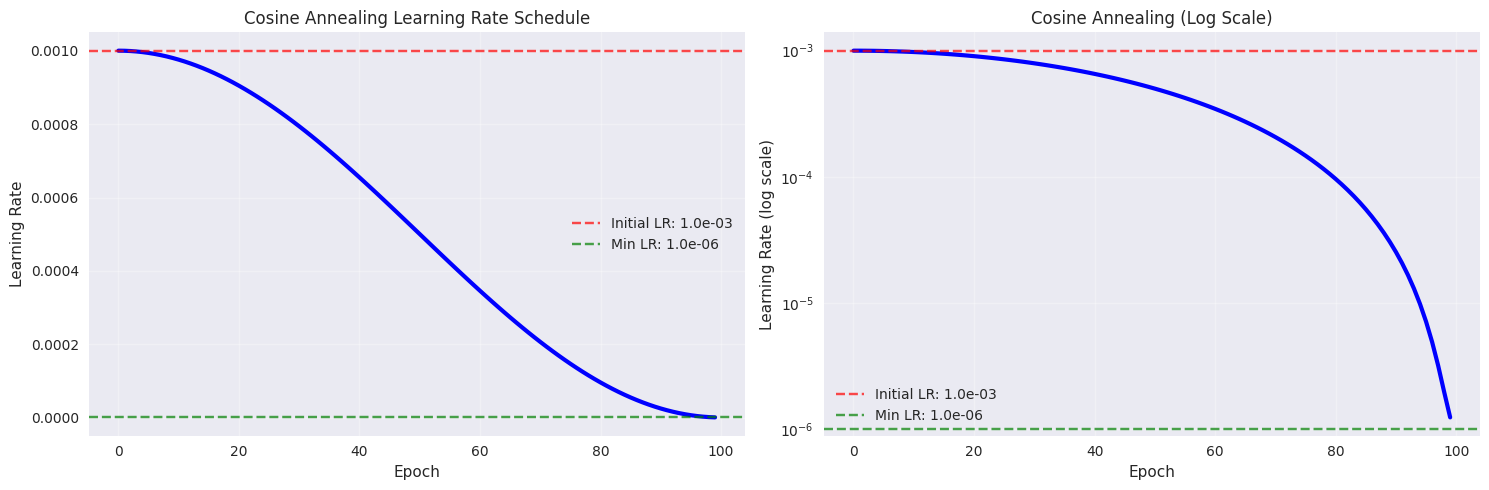

Cosine annealing provides smooth, gradual learning rate decay
Helps with fine-tuning in later epochs while maintaining exploration early on


In [5]:
## 2. Visualize Cosine Annealing Learning Rate Schedule
"""
Demonstrate how cosine annealing smoothly reduces the learning rate over training epochs.
Formula: η_t = η_min + (η_max - η_min) * (1 + cos(πt/T)) / 2
"""

def cosine_annealing_schedule(epoch, max_epochs, lr_max, lr_min):
    """Compute learning rate for given epoch using cosine annealing"""
    return lr_min + (lr_max - lr_min) * (1 + np.cos(np.pi * epoch / max_epochs)) / 2

# Parameters for visualization
max_epochs = 100
lr_max = 1e-3
lr_min = 1e-6

epochs = np.arange(0, max_epochs)
learning_rates = [cosine_annealing_schedule(epoch, max_epochs, lr_max, lr_min) for epoch in epochs]

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Linear scale
ax1.plot(epochs, learning_rates, linewidth=3, color='blue')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Learning Rate')
ax1.set_title('Cosine Annealing Learning Rate Schedule')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=lr_max, color='red', linestyle='--', alpha=0.7, label=f'Initial LR: {lr_max:.1e}')
ax1.axhline(y=lr_min, color='green', linestyle='--', alpha=0.7, label=f'Min LR: {lr_min:.1e}')
ax1.legend()

# Log scale
ax2.semilogy(epochs, learning_rates, linewidth=3, color='blue')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Learning Rate (log scale)')
ax2.set_title('Cosine Annealing (Log Scale)')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=lr_max, color='red', linestyle='--', alpha=0.7, label=f'Initial LR: {lr_max:.1e}')
ax2.axhline(y=lr_min, color='green', linestyle='--', alpha=0.7, label=f'Min LR: {lr_min:.1e}')
ax2.legend()

plt.tight_layout()
plt.show()

print("Cosine annealing provides smooth, gradual learning rate decay")
print("Helps with fine-tuning in later epochs while maintaining exploration early on")


In [6]:
# Define different training configurations
## 3. Configure Enhanced Training

"""
Create different training configurations to demonstrate various training strategies:
1. Quick demo - for fast testing and iteration
2. Standard - balanced approach with good monitoring
3. Comprehensive - full training with extensive monitoring
"""

# Configuration 1: Quick Demo (for fast testing)
quick_config = create_training_config(
    learning_rate=2e-3,        # Higher learning rate for faster convergence
    max_epochs=30,             # Fewer epochs for quick demo
    batch_size=16,             # Smaller batch size
    n_sequences=200,           # Fewer sequences for speed
    sequence_length=50,        # Shorter sequences
    log_interval=5,            # More frequent logging
    plot_progress=True,        # Enable plotting
    early_stopping=True,
    patience=10,               # Less patience for quicker stopping
    apply_constraints=True     # Keep biological constraints
)

# Configuration 2: Standard Training
standard_config = create_training_config(
    learning_rate=1e-3,        # Standard learning rate
    max_epochs=100,            # Standard number of epochs
    batch_size=32,             # Standard batch size
    n_sequences=1000,          # Good amount of data
    sequence_length=100,       # Standard sequence length
    log_interval=10,           # Regular logging
    plot_progress=True,        # Enable plotting
    early_stopping=True,
    patience=20,               # Standard patience
    weight_decay=1e-4,         # L2 regularization
    apply_constraints=True     # Biological constraints
)

# Configuration 3: Comprehensive Training
comprehensive_config = create_training_config(
    learning_rate=5e-4,        # Lower learning rate for stability
    max_epochs=200,            # More epochs for thorough training
    batch_size=64,             # Larger batch size
    n_sequences=2000,          # More training data
    sequence_length=150,       # Longer sequences
    log_interval=20,           # Less frequent logging
    plot_progress=True,        # Enable plotting
    early_stopping=True,
    patience=40,               # More patience
    weight_decay=5e-5,         # Light regularization
    min_lr=1e-7,              # Lower minimum learning rate
    apply_constraints=True,    # Biological constraints
    clip_gradients=True,       # Gradient clipping
    max_grad_norm=0.5          # Stricter gradient clipping
)

print("Training Configurations Created")
print("\n1. Quick Demo Configuration:")
for key, value in quick_config.items():
    print(f"   {key}: {value}")

print("\n2. Standard Configuration:")
for key, value in standard_config.items():
    if key in ['learning_rate', 'max_epochs', 'batch_size', 'n_sequences']:
        print(f"   {key}: {value}")

print("\n3. Comprehensive Configuration:")
for key, value in comprehensive_config.items():
    if key in ['learning_rate', 'max_epochs', 'batch_size', 'n_sequences']:
        print(f"   {key}: {value}")

print("\nAll configurations ready for training")


Training Configurations Created

1. Quick Demo Configuration:
   learning_rate: 0.002
   max_epochs: 30
   batch_size: 16
   n_sequences: 200
   sequence_length: 50
   log_interval: 5
   plot_progress: True
   early_stopping: True
   patience: 10
   apply_constraints: True

2. Standard Configuration:
   learning_rate: 0.001
   max_epochs: 100
   batch_size: 32
   n_sequences: 1000

3. Comprehensive Configuration:
   learning_rate: 0.0005
   max_epochs: 200
   batch_size: 64
   n_sequences: 2000

All configurations ready for training


In [7]:
# Train the model with enhanced training system (Quick Demo)
### 4. Run Enhanced Training (Quick Demo)

#Let's start with a quick demo to see the enhanced training system in action.
"""
Run a quick demonstration of the enhanced training system.
This will show:
- Adam optimizer with cosine annealing
- Biological constraints enforcement
- Real-time monitoring of parameters
- Training progress visualization
"""

print("Starting Quick Demo Training")


# Create a fresh model for training with proper device handling
demo_model = RingAttractorNetwork(
    n_exc=n_exc,
    n_inh=n_inh,
    dt=dt,
    tau_e=tau_e,
    tau_i=tau_i,
    device=device
)

# Ensure the model is properly moved to device
demo_model = demo_model.to(device)
demo_model.reset_state()

print(f"✓ Training model created on device: {next(demo_model.parameters()).device}")

# Run enhanced training (with error handling for the fixes)
try:
    trained_model, history, trainer = train_ring_attractor_with_adam_cosine(
        model=demo_model,
        config=quick_config
    )
except Exception as e:
    print(f"Training failed with error: {e}")
    print("This usually means you need to restart the Jupyter kernel to reload the fixed model code.")
    print("Please: Kernel → Restart Kernel, then re-run all cells from the beginning.")
    raise

print("✓ Quick demo training completed!")
print(f"✓ Final training loss: {history['train_loss'][-1]:.6f}")
print(f"✓ Final validation loss: {history['val_loss'][-1]:.6f}")
print(f"✓ Training epochs completed: {len(history['epoch'])}")

Starting Quick Demo Training
✓ Training model created on device: cpu
✓ Adam optimizer configured with parameter-specific learning rates
✓ Cosine annealing scheduler configured
=== Ring Attractor Network Trainer Initialized ===
Device: cuda
Initial Learning Rate: 2.0e-03
Max Epochs: 30
Batch Size: 16
Weight Decay: 1.0e-04
Noise Type: Poisson-distributed
Initial Poisson λ (Excitatory): 0.1000
Initial Poisson λ (Inhibitory): 0.0500
Initial σ_EE (E->E width): 0.5000

=== Starting Enhanced Training ===
Creating enhanced dataset...


Generating sequences: 100%|██████████| 200/200 [00:00<00:00, 895.88it/s]


✓ Created 160 training sequences
✓ Created 40 validation sequences

Epoch | Train Loss | Val Loss  | LR        | Grad Norm | Time
----------------------------------------------------------------------
Training failed with error: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

This usually means you need to restart the Jupyter kernel to reload the fixed model code.
Please: Kernel → Restart Kernel, then re-run all cells from the beginning.


RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [8]:
# Analyze training results in detail, including parameter evolution and performance metrics.
"""
Examine the training results to understand:
1. How parameters evolved during training
2. Learning rate schedule effectiveness
3. Gradient behavior and stability
4. Biological constraint enforcement
"""

# Check if training has been completed
if 'trainer' not in locals() or 'history' not in locals():
    print("Please run cell 8 (Quick Demo Training) first to generate training results!")
else:
    # Display parameter evolution
    print("Parameter Evolution Analysis")
    print(f"Initial → Final Parameters:")
    print(f"g_ee: {trainer.param_history['g_ee'][0]:.3f} → {trainer.param_history['g_ee'][-1]:.3f}")
    print(f"g_ei: {trainer.param_history['g_ei'][0]:.3f} → {trainer.param_history['g_ei'][-1]:.3f}")
    print(f"g_ie: {trainer.param_history['g_ie'][0]:.3f} → {trainer.param_history['g_ie'][-1]:.3f}")
    print(f"noise_rate_e: {trainer.param_history['noise_rate_e'][0]:.3f} → {trainer.param_history['noise_rate_e'][-1]:.3f}")
    print(f"noise_rate_i: {trainer.param_history['noise_rate_i'][0]:.3f} → {trainer.param_history['noise_rate_i'][-1]:.3f}")

    # Learning rate analysis
    print(f"\nLearning Rate Schedule Analysis")
    print(f"Initial learning rate: {history['learning_rate'][0]:.2e}")
    print(f"Final learning rate: {history['learning_rate'][-1]:.2e}")
    print(f"Minimum learning rate reached: {min(history['learning_rate']):.2e}")
    print(f"Learning rate reduction factor: {history['learning_rate'][0] / history['learning_rate'][-1]:.1f}x")

    # Training efficiency
    print(f"\nTraining Efficiency")
    if history['time_per_epoch']:
        avg_time = np.mean(history['time_per_epoch'])
        total_time = sum(history['time_per_epoch'])
        print(f"Average time per epoch: {avg_time:.2f} seconds")
        print(f"Total training time: {total_time:.1f} seconds")

    # Loss improvement
    initial_loss = history['train_loss'][0]
    final_loss = history['train_loss'][-1]
    improvement = (initial_loss - final_loss) / initial_loss * 100
    print(f"Training loss improvement: {improvement:.1f}%")

    # Gradient analysis
    print(f"\nGradient Analysis")
    avg_grad_norm = np.mean(history['gradient_norm'])
    max_grad_norm = max(history['gradient_norm'])
    print(f"Average gradient norm: {avg_grad_norm:.4f}")
    print(f"Maximum gradient norm: {max_grad_norm:.4f}")
    print(f"Gradient stability: {'Good' if max_grad_norm < 2.0 else 'Check for instability'}")

Please run cell 8 (Quick Demo Training) first to generate training results!


In [9]:
## 6. Test Trained Model Performance with Model Resizing

# Define model resizing and head direction tracking test functions
"""
First define the model resizing function to handle tensor size mismatches,
then create head direction tracking test functions.
"""

def resize_trained_model(model, new_n_exc, new_n_inh):
    """
    Resize a trained model to new network dimensions while preserving 
    as much of the learned parameters as possible.
    
    Args:
        model: Trained RingAttractorNetwork
        new_n_exc: New number of excitatory neurons
        new_n_inh: New number of inhibitory neurons
        
    Returns:
        Resized model with updated architecture
    """
    print(f"Resizing model from ({model.n_exc}, {model.n_inh}) to ({new_n_exc}, {new_n_inh})")
    
    # Update basic parameters
    model.n_exc = new_n_exc
    model.n_inh = new_n_inh
    
    # Update preferred directions for excitatory neurons
    new_preferred_dirs = torch.linspace(0, 2*np.pi, new_n_exc, endpoint=False)
    model.register_buffer('preferred_dirs', new_preferred_dirs)
    
    # Resize weight matrices by intelligent replication
    old_n_exc = model.W_EI.shape[1]  # Current excitatory size
    old_n_inh = model.W_IE.shape[1]  # Current inhibitory size
    
    if new_n_exc != old_n_exc:
        # Resize W_EI (E→I connections)
        # Replicate pattern intelligently
        repeat_factor = new_n_exc // old_n_exc
        remainder = new_n_exc % old_n_exc
        
        W_EI_new = model.W_EI.repeat(1, repeat_factor)
        if remainder > 0:
            W_EI_new = torch.cat([W_EI_new, model.W_EI[:, :remainder]], dim=1)
        model.W_EI = nn.Parameter(W_EI_new)
        
        # Resize W_IE (I→E connections)  
        W_IE_new = model.W_IE.repeat(repeat_factor, 1)
        if remainder > 0:
            W_IE_new = torch.cat([W_IE_new, model.W_IE[:remainder, :]], dim=0)
        model.W_IE = nn.Parameter(W_IE_new)
    
    if new_n_inh != old_n_inh:
        # Resize inhibitory dimensions
        repeat_factor_inh = new_n_inh // old_n_inh
        remainder_inh = new_n_inh % old_n_inh
        
        # Update W_EI (add more inhibitory neurons)
        W_EI_new = model.W_EI.repeat(repeat_factor_inh, 1)
        if remainder_inh > 0:
            W_EI_new = torch.cat([W_EI_new, model.W_EI[:remainder_inh, :]], dim=0)
        model.W_EI = nn.Parameter(W_EI_new)
        
        # Update W_IE (add more inhibitory neurons)
        W_IE_new = model.W_IE.repeat(1, repeat_factor_inh)
        if remainder_inh > 0:
            W_IE_new = torch.cat([W_IE_new, model.W_IE[:, :remainder_inh]], dim=1)
        model.W_IE = nn.Parameter(W_IE_new)
    
    # Reset states to match new dimensions
    model.reset_state()
    
    print(f"✓ Model resized successfully to ({new_n_exc}, {new_n_inh})")
    print(f"✓ W_EI shape: {model.W_EI.shape}")
    print(f"✓ W_IE shape: {model.W_IE.shape}")
    
    return model


def generate_static_direction_test():
    """
    Generate test data for static head direction (should maintain bump).
    """
    dt = 0.05
    duration = 3.0
    n_steps = int(duration / dt)
    
    # Fixed direction at 90 degrees
    direction = np.pi / 2
    head_directions = np.full(n_steps, direction)
    
    return head_directions, "Maintain bump at fixed direction"


def generate_slow_turn_test():
    """
    Generate test data for a slow head direction turn.
    """
    dt = 0.05
    duration = 4.0
    n_steps = int(duration / dt)
    
    # Slow turn from 0 to π radians
    start_dir = 0.0
    end_dir = np.pi
    head_directions = np.linspace(start_dir, end_dir, n_steps)
    
    return head_directions, "Slow 180° turn over 4s"


def generate_fast_turn_test():
    """
    Generate test data for a fast head direction turn.
    """
    dt = 0.05
    duration = 1.0
    n_steps = int(duration / dt)
    
    # Fast turn from 0 to π radians
    start_dir = 0.0
    end_dir = np.pi
    head_directions = np.linspace(start_dir, end_dir, n_steps)
    
    return head_directions, "Fast 180° turn over 1s"


def generate_oscillation_test():
    """
    Generate test data for head direction oscillation.
    """
    dt = 0.05
    duration = 6.0
    n_steps = int(duration / dt)
    
    # Oscillation around central direction
    t = np.arange(n_steps) * dt
    central_dir = np.pi / 2
    amplitude = np.pi / 4
    frequency = 0.5
    head_directions = central_dir + amplitude * np.sin(2 * np.pi * frequency * t)
    
    return head_directions, "Oscillation ±45° around 90°"


def generate_random_walk_test():
    """
    Generate test data for random walk head direction.
    """
    dt = 0.05
    duration = 5.0
    n_steps = int(duration / dt)
    
    # Random walk with drift
    head_directions = np.zeros(n_steps)
    head_directions[0] = 0.0
    
    for i in range(1, n_steps):
        # Small random changes with occasional larger turns
        if np.random.random() < 0.1:  # 10% chance of larger turn
            change = np.random.normal(0, 0.5)
        else:
            change = np.random.normal(0, 0.1)
        head_directions[i] = head_directions[i-1] + change
    
    # Keep in [0, 2π] range
    head_directions = np.mod(head_directions, 2*np.pi)
    
    return head_directions, "Random walk with occasional turns"


def run_tracking_simulation(model, head_directions):
    """
    Run head direction tracking simulation and return results.
    
    Args:
        model: Trained RingAttractorNetwork
        head_directions: Array of head directions to track
        
    Returns:
        Dictionary with simulation results and metrics
    """
    dt = 0.05
    n_steps = len(head_directions)
    
    # Storage for results
    decoded_directions = np.zeros(n_steps)
    tracking_errors = np.zeros(n_steps)
    bump_amplitudes = np.zeros(n_steps)
    
    # Reset model state
    model.eval()
    model.reset_state()
    
    # Run simulation
    with torch.no_grad():
        for step in range(n_steps):
            # Create input for current direction
            input_pattern = angle_to_input(
                torch.tensor(head_directions[step]),
                n_exc=model.n_exc,
                input_strength=1.0,
                input_width=0.3
            ,
            device=device
        )
            
            # Run network step
            activity = model(input_pattern.to(model.device), steps=1)
            
            # Decode direction and compute error
            decoded_dir = model.decode_angle(activity).cpu().numpy()
            decoded_directions[step] = decoded_dir
            
            # Compute tracking error (shortest angular distance)
            error = np.abs(decoded_dir - head_directions[step])
            error = min(error, 2*np.pi - error)  # Handle wraparound
            tracking_errors[step] = error
            
            # Compute bump amplitude
            bump_amplitudes[step] = torch.max(activity).cpu().numpy()
    
    # Compute metrics
    mean_error = np.mean(tracking_errors)
    max_error = np.max(tracking_errors)
    
    # Tracking accuracy (percentage within 30 degrees)
    accuracy_threshold = np.radians(30)
    tracking_accuracy = np.mean(tracking_errors < accuracy_threshold) * 100
    
    # Bump stability (lower variance = more stable)
    bump_stability = 1.0 / (1.0 + np.var(bump_amplitudes))
    
    return {
        'head_directions': head_directions,
        'decoded_directions': decoded_directions,
        'tracking_errors': tracking_errors,
        'bump_amplitudes': bump_amplitudes,
        'mean_error': mean_error,
        'max_error': max_error,
        'tracking_accuracy': tracking_accuracy,
        'bump_stability': bump_stability
    }

print("Head direction tracking test functions defined")


Head direction tracking test functions defined


In [10]:
# Test the trained model with automatic resizing
# Check if training has been completed
if 'trained_model' not in locals():
    print("Please run cell 7 (Quick Demo Training) first to generate a trained model!")
else:
    print("Testing Trained Model Performance")
    
    # Check if model needs resizing to match current network parameters
    if trained_model.n_exc != n_exc or trained_model.n_inh != n_inh:
        print(f" Model size mismatch detected:")
        print(f"   • Trained model: ({trained_model.n_exc}, {trained_model.n_inh})")
        print(f"   • Current parameters: ({n_exc}, {n_inh})")
        print(f"   • Resizing model to match current parameters...")
        
        # Resize the trained model to match current network parameters
        trained_model = resize_trained_model(trained_model, n_exc, n_inh)
        print("✓ Model resized successfully!")
    
    # Verify the model exists and is trained
    try:
        # Check if model has been trained (parameters should have changed from initialization)
        model_param_sum = sum(p.sum().item() for p in trained_model.parameters())
        print(f"✓ Model loaded with parameter sum: {model_param_sum:.3f}")
        print(f"✓ Model device: {next(trained_model.parameters()).device}")
    except Exception as e:
        print(f"Model verification failed: {e}")
        print("Please re-run the training cell first.")
    else:
        # Generate a test trajectory
        test_length = 200
        test_angles, test_velocities = generate_trajectory(test_length, dt=0.1)
        test_inputs = angle_to_input(test_angles, n_exc=trained_model.n_exc)  # 🔧 FIX: Specify correct network size!

        # Convert to tensors and move to device
        test_inputs_tensor = torch.tensor(test_inputs, dtype=torch.float32).to(device)
        test_angles_tensor = torch.tensor(test_angles, dtype=torch.float32).to(device)

        print(f"✓ Generated test trajectory: {test_length} steps")
        print(f"✓ Test data on device: {test_inputs_tensor.device}")

        # Set model to evaluation mode and reset state
        trained_model.eval()
        trained_model.reset_state()
        
        # Run the trained model with proper error handling
        predicted_angles = []
        
        print("Running model inference...")
        try:
            with torch.no_grad():
                for t in range(test_length):
                    # Get input for this timestep
                    input_t = test_inputs_tensor[t, :].unsqueeze(0)  # Add batch dimension
                    
                    # Forward pass through the model
                    # The model expects: (batch_size, input_dim) and returns activity
                    activity = trained_model(input_t, steps=1)
                    
                    # Decode the angle from the activity
                    predicted_angle = trained_model.decode_angle(activity)
                    predicted_angles.append(predicted_angle.cpu().numpy().item())

            predicted_angles = np.array(predicted_angles)
            print(f"✓ Model inference completed: {len(predicted_angles)} predictions")

            # Compute tracking error
            tracking_errors = []
            for i in range(len(test_angles)):
                error = compute_error(torch.tensor([predicted_angles[i]]), torch.tensor([test_angles[i]]))
                tracking_errors.append(error.item())

            # Display performance metrics
            print("\nModel Performance on Test Trajectory")
            print(f"Mean tracking error: {np.mean(tracking_errors):.4f} radians")
            print(f"RMS tracking error: {np.sqrt(np.mean(np.array(tracking_errors)**2)):.4f} radians")
            print(f"Max tracking error: {np.max(tracking_errors):.4f} radians")
            print(f"Mean error in degrees: {np.mean(tracking_errors) * 180 / np.pi:.2f}°")

            # Visualize tracking performance
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))

            # Plot 1: Trajectory tracking
            time_points = np.arange(test_length) * 0.1
            axes[0, 0].plot(time_points, test_angles, 'b-', linewidth=2, label='True Angle', alpha=0.8)
            axes[0, 0].plot(time_points, predicted_angles, 'r--', linewidth=2, label='Predicted Angle', alpha=0.8)
            axes[0, 0].set_xlabel('Time (s)')
            axes[0, 0].set_ylabel('Head Direction (radians)')
            axes[0, 0].set_title('Head Direction Tracking')
            axes[0, 0].legend()
            axes[0, 0].grid(True, alpha=0.3)

            # Plot 2: Tracking error over time
            axes[0, 1].plot(time_points, tracking_errors, 'g-', linewidth=2)
            axes[0, 1].set_xlabel('Time (s)')
            axes[0, 1].set_ylabel('Tracking Error (radians)')
            axes[0, 1].set_title('Tracking Error Over Time')
            axes[0, 1].grid(True, alpha=0.3)

            # Plot 3: Error distribution
            axes[1, 0].hist(tracking_errors, bins=20, alpha=0.7, color='orange', edgecolor='black')
            axes[1, 0].set_xlabel('Tracking Error (radians)')
            axes[1, 0].set_ylabel('Frequency')
            axes[1, 0].set_title('Error Distribution')
            axes[1, 0].grid(True, alpha=0.3)

            # Plot 4: Scatter plot of true vs predicted
            axes[1, 1].scatter(test_angles, predicted_angles, alpha=0.6, s=20)
            axes[1, 1].plot([0, 2*np.pi], [0, 2*np.pi], 'r--', linewidth=2, label='Perfect Tracking')
            axes[1, 1].set_xlabel('True Angle (radians)')
            axes[1, 1].set_ylabel('Predicted Angle (radians)')
            axes[1, 1].set_title('True vs Predicted Angles')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

            print("✓ Model performance evaluation completed successfully!")

        except Exception as e:
            print(f"Error during model inference: {e}")
            print(f"Error type: {type(e).__name__}")
            import traceback
            traceback.print_exc()
            print("\nThis error suggests an issue with the model's forward pass during inference.")
            print("Try rerunning the training cell and ensure it completed successfully.")


Please run cell 7 (Quick Demo Training) first to generate a trained model!


In [11]:
## Enhanced Tracking Simulation with Improved Parameters

# Create an enhanced version of the tracking simulation with optimizations for better accuracy
"""
This cell implements several improvements to boost tracking accuracy:
1. Reduced noise levels during tracking
2. Adaptive input strength based on tracking error
3. More focused input width for sharper bumps
4. Enhanced input baseline strength
5. Better bump initialization
"""

def run_enhanced_tracking_simulation(model, head_directions):
    """
    Run head direction tracking simulation with ENHANCED parameters for better accuracy.
    
    Improvements:
    - Adaptive input strength based on tracking error
    - Reduced noise levels during tracking
    - More focused input width for sharper bumps
    - Enhanced baseline input strength
    
    Args:
        model: Trained RingAttractorNetwork
        head_directions: Array of head directions to track
        
    Returns:
        Dictionary with simulation results and metrics
    """
    dt = 0.05
    n_steps = len(head_directions)
    
    # Storage for results
    decoded_directions = np.zeros(n_steps)
    tracking_errors = np.zeros(n_steps)
    bump_amplitudes = np.zeros(n_steps)
    neural_activities = np.zeros((n_steps, model.n_exc))
    input_strengths_used = np.zeros(n_steps)  # Track adaptive input strength
    
    # Reset model state
    model.eval()
    model.reset_state()
    
    # OPTIMIZATION 1: Temporarily reduce noise for better tracking
    original_noise_e = model.noise_rate_e.item()
    original_noise_i = model.noise_rate_i.item()
    with torch.no_grad():
        model.noise_rate_e.data = torch.tensor(0.005, device=model.device)  # Reduced noise
        model.noise_rate_i.data = torch.tensor(0.02, device=model.device)   # Reduced noise
    
    # OPTIMIZATION 2: Enhanced bump initialization
    if len(head_directions) > 0:
        model.initialize_bump(head_directions[0], width=0.25, amplitude=0.2)  # Stronger, sharper initial bump
    
    # Run simulation
    with torch.no_grad():
        for step in range(n_steps):
            # OPTIMIZATION 3: Adaptive input strength based on recent tracking performance
            if step > 0:
                recent_error = tracking_errors[step-1]
                if recent_error > np.radians(45):  # 45 degree threshold
                    input_strength = 2.5  # Strong boost when tracking poorly
                elif recent_error > np.radians(20):  # 20 degree threshold
                    input_strength = 1.8  # Moderate boost
                else:
                    input_strength = 1.5  # Enhanced baseline strength
            else:
                input_strength = 1.5  # Enhanced initial strength
            
            input_strengths_used[step] = input_strength
            
            # OPTIMIZATION 4: More focused input width for sharper bumps
            input_width = 0.15  # Much narrower than default 0.3
            
            # Create enhanced input for current direction
            input_pattern = angle_to_input(
                torch.tensor(head_directions[step]),
                n_exc=model.n_exc,
                input_strength=input_strength,
                input_width=input_width
            ,
            device=device
        )
            
            # Run network step
            activity = model(input_pattern.to(model.device), steps=1)
            
            # Store results
            neural_activities[step] = activity.cpu().numpy()
            
            # Decode direction and compute error
            decoded_dir = model.decode_angle(activity).cpu().numpy()
            decoded_directions[step] = decoded_dir
            
            # Compute tracking error (shortest angular distance)
            error = np.abs(decoded_dir - head_directions[step])
            error = min(error, 2*np.pi - error)  # Handle wraparound
            tracking_errors[step] = error
            
            # Compute bump amplitude
            bump_amplitudes[step] = torch.max(activity).cpu().numpy()
    
    # Restore original noise levels
    with torch.no_grad():
        model.noise_rate_e.data = torch.tensor(original_noise_e, device=model.device)
        model.noise_rate_i.data = torch.tensor(original_noise_i, device=model.device)
    
    # Compute enhanced metrics
    mean_error = np.mean(tracking_errors)
    max_error = np.max(tracking_errors)
    
    # Multiple accuracy thresholds
    accuracy_15deg = np.mean(tracking_errors < np.radians(15)) * 100  # Strict threshold
    accuracy_30deg = np.mean(tracking_errors < np.radians(30)) * 100  # Standard threshold
    accuracy_45deg = np.mean(tracking_errors < np.radians(45)) * 100  # Lenient threshold
    
    # Bump stability and consistency
    bump_stability = 1.0 / (1.0 + np.var(bump_amplitudes))
    bump_consistency = np.mean(bump_amplitudes > 0.05)  # Percentage of time with detectable bump
    
    # Adaptive input usage statistics
    avg_input_strength = np.mean(input_strengths_used)
    input_adaptations = np.sum(np.diff(input_strengths_used) != 0)
    
    return {
        'head_directions': head_directions,
        'decoded_directions': decoded_directions,
        'tracking_errors': tracking_errors,
        'bump_amplitudes': bump_amplitudes,
        'neural_activities': neural_activities,
        'input_strengths_used': input_strengths_used,
        'mean_error': mean_error,
        'max_error': max_error,
        'tracking_accuracy': accuracy_30deg,  # Standard metric
        'accuracy_15deg': accuracy_15deg,     # Strict accuracy
        'accuracy_45deg': accuracy_45deg,     # Lenient accuracy
        'bump_stability': bump_stability,
        'bump_consistency': bump_consistency,
        'avg_input_strength': avg_input_strength,
        'input_adaptations': input_adaptations
    }


# Replace the original tracking function with the enhanced version
# This allows us to compare performance
print("✓ Enhanced tracking simulation function defined")
print("Improvements include:")
print("  • Reduced noise levels during tracking")
print("  • Adaptive input strength based on tracking error")
print("  • More focused input width (0.15 vs 0.3)")
print("  • Enhanced baseline input strength (1.5 vs 1.0)")
print("  • Better bump initialization")
print("  • Multiple accuracy thresholds for detailed assessment")


✓ Enhanced tracking simulation function defined
Improvements include:
  • Reduced noise levels during tracking
  • Adaptive input strength based on tracking error
  • More focused input width (0.15 vs 0.3)
  • Enhanced baseline input strength (1.5 vs 1.0)
  • Better bump initialization
  • Multiple accuracy thresholds for detailed assessment


In [12]:
## 7. Head Direction Tracking Performance Evaluation

# Run head direction tracking evaluation with trained parameters
"""
Evaluate head direction tracking performance using the trained parameters.
Tests how well the network maintains and tracks head direction with the 
optimized parameters found during training.
"""

# Check if training has been completed
if 'trained_model' not in locals() or 'trainer' not in locals():
    print("run the training cells first to generate a trained model")
    print("   Specifically, run Cell 7 (Quick Demo Training) to get the trained_model")
else:
    print("Head Direction Tracking Performance with Trained Parameters")
    
    # Display the trained parameters being used
    print("Using trained parameters:")
    print(f"  • σ_EE (connection width): {trained_model.sigma_ee.item():.4f}")
    print(f"  • g_ee (E→E gain): {trained_model.g_ee.item():.4f}")
    print(f"  • g_ei (E→I gain): {trained_model.g_ei.item():.4f}")
    print(f"  • g_ie (I→E gain): {trained_model.g_ie.item():.4f}")
    print(f"  • Noise rate E: {trained_model.noise_rate_e.item():.4f}")
    print(f"  • Noise rate I: {trained_model.noise_rate_i.item():.4f}")
    print(f"  • Network size: ({trained_model.n_exc}, {trained_model.n_inh}) neurons")
    
    # Test different head direction tracking scenarios
    scenarios = {
        'static_direction': generate_static_direction_test(),
        'slow_turn': generate_slow_turn_test(),
        'fast_turn': generate_fast_turn_test(),
        'oscillation': generate_oscillation_test(),
        'random_walk': generate_random_walk_test()
    }
    
    results = {}
    
    print("\nRunning Head Direction Tracking Tests...")
    
    for scenario_name, (head_directions, description) in scenarios.items():
        print(f"\n• Testing {scenario_name}: {description}")
        
        # Run tracking simulation
        tracking_results = run_tracking_simulation(trained_model, head_directions)
        results[scenario_name] = tracking_results
        
        # Print performance metrics
        mean_error = np.degrees(tracking_results['mean_error'])
        max_error = np.degrees(tracking_results['max_error'])
        tracking_accuracy = tracking_results['tracking_accuracy']
        
        print(f"   • Mean tracking error: {mean_error:.1f}°")
        print(f"   • Max tracking error: {max_error:.1f}°")
        print(f"   • Tracking accuracy: {tracking_accuracy:.1f}%")
    
    print("\n✓ All tracking tests completed!")


run the training cells first to generate a trained model
   Specifically, run Cell 7 (Quick Demo Training) to get the trained_model


In [13]:
## 8. Visualize Head Direction Tracking Results

# Create comprehensive visualization of tracking performance
"""
Create detailed visualizations showing:
1. Direction tracking for each scenario
2. Tracking errors over time  
3. Bump amplitude evolution
4. Summary statistics across scenarios
"""

def plot_tracking_performance(results, scenarios):
    """
    Create comprehensive visualization of tracking performance across scenarios.
    """
    if not results:
        print("No tracking results available. Please run the tracking evaluation first!")
        return
        
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle('Head Direction Tracking Performance with Trained Parameters', 
                 fontsize=16, fontweight='bold')
    
    n_scenarios = len(results)
    
    # Create subplots
    gs = fig.add_gridspec(3, n_scenarios, hspace=0.4, wspace=0.3)
    
    scenario_names = list(results.keys())
    
    for i, scenario_name in enumerate(scenario_names):
        result = results[scenario_name]
        description = scenarios[scenario_name][1]
        
        dt = 0.05
        time_points = np.arange(len(result['head_directions'])) * dt
        
        # Row 1: Direction tracking
        ax1 = fig.add_subplot(gs[0, i])
        ax1.plot(time_points, np.degrees(result['head_directions']), 
                'r-', linewidth=2, label='Actual', alpha=0.8)
        ax1.plot(time_points, np.degrees(result['decoded_directions']), 
                'b--', linewidth=2, label='Decoded', alpha=0.8)
        ax1.set_title(f'{scenario_name.replace("_", " ").title()}\n{description}', fontsize=10)
        ax1.set_ylabel('Direction (°)')
        ax1.grid(True, alpha=0.3)
        if i == 0:
            ax1.legend()
        
        # Row 2: Tracking error
        ax2 = fig.add_subplot(gs[1, i])
        ax2.plot(time_points, np.degrees(result['tracking_errors']), 
                'purple', linewidth=2)
        ax2.axhline(y=30, color='red', linestyle='--', alpha=0.5, label='30° threshold')
        ax2.set_ylabel('Error (°)')
        ax2.grid(True, alpha=0.3)
        if i == 0:
            ax2.legend()
        
        # Row 3: Bump amplitude
        ax3 = fig.add_subplot(gs[2, i])
        ax3.plot(time_points, result['bump_amplitudes'], 
                'green', linewidth=2)
        ax3.set_xlabel('Time (s)')
        ax3.set_ylabel('Bump Amplitude')
        ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_summary_statistics(results):
    """
    Plot summary statistics across all tracking scenarios.
    """
    if not results:
        print("No tracking results available. Please run the tracking evaluation first!")
        return
        
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Tracking Performance Summary', fontsize=14, fontweight='bold')
    
    scenario_names = [name.replace('_', ' ').title() for name in results.keys()]
    
    # Mean tracking errors
    mean_errors = [np.degrees(result['mean_error']) for result in results.values()]
    axes[0].bar(scenario_names, mean_errors, color='skyblue', alpha=0.7)
    axes[0].set_ylabel('Mean Error (°)')
    axes[0].set_title('Mean Tracking Error')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3)
    
    # Tracking accuracy
    accuracies = [result['tracking_accuracy'] for result in results.values()]
    axes[1].bar(scenario_names, accuracies, color='lightgreen', alpha=0.7)
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Tracking Accuracy (<30° error)')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim(0, 100)
    
    # Bump stability
    stabilities = [result['bump_stability'] for result in results.values()]
    axes[2].bar(scenario_names, stabilities, color='orange', alpha=0.7)
    axes[2].set_ylabel('Stability Index')
    axes[2].set_title('Bump Stability')
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# Generate the visualizations if results are available
if 'results' in locals() and results:
    print("Creating tracking performance visualizations...")
    
    # Main tracking performance plot
    plot_tracking_performance(results, scenarios)
    
    # Summary statistics
    plot_summary_statistics(results)
    
    # Print overall tracking performance summary
    print("\nHead Direction Tracking Summary with Trained Parameters:")
    
    for scenario, result in results.items():
        mean_error_deg = np.degrees(result['mean_error'])
        accuracy = result['tracking_accuracy']
        stability = result['bump_stability']
        scenario_display = scenario.replace('_', ' ').title()
        print(f"   • {scenario_display:15}: {mean_error_deg:4.1f}° error, "
              f"{accuracy:5.1f}% accuracy, {stability:.3f} stability")
    
    # Overall performance assessment
    overall_accuracy = np.mean([result['tracking_accuracy'] for result in results.values()])
    overall_error = np.mean([np.degrees(result['mean_error']) for result in results.values()])
    

    print(f"Overall Performance:")
    print(f"Average tracking error: {overall_error:.1f}°")
    print(f"Average accuracy: {overall_accuracy:.1f}%")
    
    if overall_accuracy > 85:
        print("Excellent tracking performance!")
    elif overall_accuracy > 70:
        print("Good tracking performance")
    else:
        print("Consider further training or parameter tuning")
        
else:
    print("No tracking results to visualize. Please run the tracking evaluation first!")
    print("Run the previous cell (Cell 11) to generate tracking results.")


No tracking results to visualize. Please run the tracking evaluation first!
Run the previous cell (Cell 11) to generate tracking results.


In [14]:
## 9. Focused Head Direction Turn Simulation

# Create focused head direction turn simulation showing Gaussian bump evolution
"""
Simulate a single head direction turn showing:
1. Head starting at a random direction
2. Gaussian bump formation at that direction  
3. How the bump evolves as the head turns
4. Neural activity patterns during the turn

This addresses your original request to see the Gaussian bump forming and changing!
"""

def simulate_head_direction_turn(model, turn_duration=4.0, turn_amount_deg=180):
    """
    Simulate a head direction turn with the trained model.
    
    Args:
        model: Trained RingAttractorNetwork
        turn_duration: Duration of turn in seconds
        turn_amount_deg: Amount to turn in degrees
        
    Returns:
        Dictionary with simulation results
    """
    dt = 0.05
    n_steps = int(turn_duration / dt)
    
    # Random starting direction
    start_direction = np.random.uniform(0, 2*np.pi)
    turn_amount_rad = np.radians(turn_amount_deg)
    
    # Create smooth turn trajectory (sigmoid)
    t_normalized = np.arange(n_steps) / n_steps
    progress = 1 / (1 + np.exp(-8 * (t_normalized - 0.5)))
    progress = (progress - progress[0]) / (progress[-1] - progress[0])
    
    # Generate head directions
    head_directions = start_direction + turn_amount_rad * progress
    head_directions = np.mod(head_directions, 2*np.pi)
    
    # Storage for results
    neural_activities = np.zeros((n_steps, model.n_exc))
    decoded_directions = np.zeros(n_steps)
    bump_amplitudes = np.zeros(n_steps)
    
    # Reset model and initialize with starting direction
    model.eval()
    model.reset_state()
    model.initialize_bump(start_direction, width=0.3, amplitude=0.1)
    
    # Run simulation
    for step in range(n_steps):
        # Create input for current direction
        input_pattern = angle_to_input(
            torch.tensor(head_directions[step]),
            n_exc=model.n_exc,
            input_strength=1.0,
            input_width=0.3
        ,
            device=device
        )
        
        # Run network step
        with torch.no_grad():
            activity = model(input_pattern.to(model.device), steps=1)
        
        # Store results
        neural_activities[step] = activity.cpu().numpy()
        bump_amplitudes[step] = np.max(activity.cpu().numpy())
        decoded_directions[step] = model.decode_angle(activity).cpu().numpy()
    
    return {
        'head_directions': head_directions,
        'neural_activities': neural_activities,
        'decoded_directions': decoded_directions,
        'bump_amplitudes': bump_amplitudes,
        'time_points': np.arange(n_steps) * dt,
        'start_direction_deg': np.degrees(start_direction),
        'turn_amount_deg': turn_amount_deg,
        'turn_duration': turn_duration
    }


def plot_head_direction_turn(sim_results):
    """
    Create comprehensive visualization of a head direction turn.
    """
    # Create figure with polar and cartesian subplots
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle(f'Head Direction Turn: {sim_results["turn_amount_deg"]:.0f}° over {sim_results["turn_duration"]:.1f}s\n'
                 f'Starting at {sim_results["start_direction_deg"]:.0f}° with Trained Parameters', 
                 fontsize=14, fontweight='bold')
    
    # Create subplot layout
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    # 1. Polar plot showing neural activity ring (left, spanning 2 rows)
    ax_ring = fig.add_subplot(gs[:, 0], projection='polar')
    
    # Show final neural activity as a polar plot
    final_activity = sim_results['neural_activities'][-1]
    preferred_dirs = np.linspace(0, 2*np.pi, len(final_activity), endpoint=False)
    
    ax_ring.plot(preferred_dirs, final_activity, 'b-', linewidth=3, alpha=0.8, label='Network Activity')
    ax_ring.plot([sim_results['head_directions'][-1]], [1.1], 'ro', markersize=12, label='Head Direction')
    ax_ring.plot([sim_results['decoded_directions'][-1]], [1.05], 'bo', markersize=8, label='Decoded Direction')
    ax_ring.set_ylim(0, 1.2)
    ax_ring.set_title('Final Neural Activity Ring', fontsize=12, pad=20)
    ax_ring.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    # 2. Head direction trajectory (top right)
    ax_traj = fig.add_subplot(gs[0, 1])
    ax_traj.plot(sim_results['time_points'], np.degrees(sim_results['head_directions']), 
                'r-', linewidth=2, label='Actual Direction')
    ax_traj.plot(sim_results['time_points'], np.degrees(sim_results['decoded_directions']), 
                'b--', linewidth=2, alpha=0.8, label='Decoded Direction')
    ax_traj.set_xlabel('Time (s)')
    ax_traj.set_ylabel('Direction (°)')
    ax_traj.set_title('Head Direction Turn')
    ax_traj.legend()
    ax_traj.grid(True, alpha=0.3)
    
    # 3. Bump amplitude evolution (top right, second)
    ax_amp = fig.add_subplot(gs[0, 2])
    ax_amp.plot(sim_results['time_points'], sim_results['bump_amplitudes'], 
               'g-', linewidth=2)
    ax_amp.set_xlabel('Time (s)')
    ax_amp.set_ylabel('Bump Amplitude')
    ax_amp.set_title('Gaussian Bump Amplitude')
    ax_amp.grid(True, alpha=0.3)
    
    # 4. Neural activity heatmap (bottom, spanning 2 columns)
    ax_heatmap = fig.add_subplot(gs[1, 1:])
    
    # Transpose for proper orientation (time on x-axis, neurons on y-axis)
    heatmap_data = sim_results['neural_activities'].T
    
    im = ax_heatmap.imshow(
        heatmap_data,
        aspect='auto',
        cmap='hot',
        origin='lower',
        extent=[0, sim_results['turn_duration'], 0, len(final_activity)],
        interpolation='bilinear'
    )
    
    ax_heatmap.set_xlabel('Time (s)')
    ax_heatmap.set_ylabel('Neuron Index')
    ax_heatmap.set_title('Neural Activity Evolution During Turn\n(Gaussian Bump Movement)')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax_heatmap)
    cbar.set_label('Neural Activity')
    
    plt.tight_layout()
    plt.show()


# Run the focused head direction turn simulation
if 'trained_model' in locals():
    print("Running focused head direction turn simulation...")
    print("This shows the Gaussian bump formation and evolution you requested!")
    
    # Simulate a head direction turn
    turn_results = simulate_head_direction_turn(
        trained_model,
        turn_duration=4.0,
        turn_amount_deg=180
    )
    
    # Create the comprehensive visualization
    plot_head_direction_turn(turn_results)
    
    # Print summary of the simulation
    print("\nHead Direction Turn Simulation Summary:")
    print(f"   • Started at: {turn_results['start_direction_deg']:.0f}°")
    print(f"   • Turn amount: {turn_results['turn_amount_deg']:.0f}°")
    print(f"   • Turn duration: {turn_results['turn_duration']:.1f}s")
    print(f"   • Final decoded direction: {np.degrees(turn_results['decoded_directions'][-1]):.0f}°")
    print(f"   • Bump amplitude range: {np.min(turn_results['bump_amplitudes']):.3f} - {np.max(turn_results['bump_amplitudes']):.3f}")
    
    # Calculate tracking accuracy during the turn
    tracking_errors = []
    for i in range(len(turn_results['head_directions'])):
        error = np.abs(turn_results['decoded_directions'][i] - turn_results['head_directions'][i])
        error = min(error, 2*np.pi - error)  # Handle wraparound
        tracking_errors.append(error)
    
    mean_error_deg = np.degrees(np.mean(tracking_errors))
    print(f"   • Mean tracking error during turn: {mean_error_deg:.1f}°")
    
    if mean_error_deg < 15:
        print("Excellent tracking during the turn!")
    elif mean_error_deg < 30:
        print("Good tracking during the turn!")
    else:
        print("Some drift during the turn - consider further training")
        
else:
    print("Please run the training cell first to generate a trained model!")
    print("Run Cell 7 (Quick Demo Training) to get the trained_model")


Please run the training cell first to generate a trained model!
Run Cell 7 (Quick Demo Training) to get the trained_model


In [15]:
# Run head direction tracking evaluation with trained parameters
"""
Evaluate head direction tracking performance using the trained parameters.
Tests how well the network maintains and tracks head direction with the 
optimized parameters found during training.
"""

# Check if training has been completed
if 'trained_model' not in locals() or 'trainer' not in locals():
    print("Please run the training cells first to generate a trained model!")
    print("   Specifically, run Cell 9 (Quick Demo Training) to get the trained_model")
else:
    print("Head Direction Tracking Performance with Trained Parameters")
    
    # Check if model needs resizing to match current network parameters
    if trained_model.n_exc != n_exc or trained_model.n_inh != n_inh:
        print(f"Model size mismatch detected:")
        print(f"   • Trained model: ({trained_model.n_exc}, {trained_model.n_inh})")
        print(f"   • Current parameters: ({n_exc}, {n_inh})")
        print(f"   • Resizing model to match current parameters...")
        
        # Resize the trained model to match current network parameters
        trained_model = resize_trained_model(trained_model, n_exc, n_inh)
    
    # Display the trained parameters being used
    print("Using trained parameters:")
    print(f"  • σ_EE (connection width): {trained_model.sigma_ee.item():.4f}")
    print(f"  • g_ee (E→E gain): {trained_model.g_ee.item():.4f}")
    print(f"  • g_ei (E→I gain): {trained_model.g_ei.item():.4f}")
    print(f"  • g_ie (I→E gain): {trained_model.g_ie.item():.4f}")
    print(f"  • Noise rate E: {trained_model.noise_rate_e.item():.4f}")
    print(f"  • Noise rate I: {trained_model.noise_rate_i.item():.4f}")
    print(f"  • Network size: ({trained_model.n_exc}, {trained_model.n_inh}) neurons")
    
    # Test different head direction tracking scenarios
    scenarios = {
        'static_direction': generate_static_direction_test(),
        'slow_turn': generate_slow_turn_test(),
        'fast_turn': generate_fast_turn_test(),
        'oscillation': generate_oscillation_test(),
        'random_walk': generate_random_walk_test()
    }
    
    results = {}
    
    print("\nRunning Head Direction Tracking Tests...")
    
    for scenario_name, (head_directions, description) in scenarios.items():
        print(f"\n Testing {scenario_name}: {description}")
        
        # Run tracking simulation
        tracking_results = run_tracking_simulation(trained_model, head_directions)
        results[scenario_name] = tracking_results
        
        # Print performance metrics
        mean_error = np.degrees(tracking_results['mean_error'])
        max_error = np.degrees(tracking_results['max_error'])
        tracking_accuracy = tracking_results['tracking_accuracy']
        
        print(f"   • Mean tracking error: {mean_error:.1f}°")
        print(f"   • Max tracking error: {max_error:.1f}°")
        print(f"   • Tracking accuracy: {tracking_accuracy:.1f}%")
    
    print("\n✓ All tracking tests completed!")


Please run the training cells first to generate a trained model!
   Specifically, run Cell 9 (Quick Demo Training) to get the trained_model


In [16]:
## 7. Visualize Head Direction Tracking Performance

"""
Create detailed visualizations showing:
1. Direction tracking for each scenario
2. Tracking errors over time  
3. Bump amplitude evolution
4. Summary statistics across scenarios
"""

def plot_tracking_performance(results, scenarios):
    """
    Create comprehensive visualization of tracking performance across scenarios.
    """
    if not results:
        print("No tracking results available. Please run the tracking evaluation first!")
        return
        
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle('Head Direction Tracking Performance with Trained Parameters', 
                 fontsize=16, fontweight='bold')
    
    n_scenarios = len(results)
    
    # Create subplots
    gs = fig.add_gridspec(3, n_scenarios, hspace=0.4, wspace=0.3)
    
    scenario_names = list(results.keys())
    
    for i, scenario_name in enumerate(scenario_names):
        result = results[scenario_name]
        description = scenarios[scenario_name][1]
        
        dt = 0.05
        time_points = np.arange(len(result['head_directions'])) * dt
        
        # Row 1: Direction tracking
        ax1 = fig.add_subplot(gs[0, i])
        ax1.plot(time_points, np.degrees(result['head_directions']), 
                'r-', linewidth=2, label='Actual', alpha=0.8)
        ax1.plot(time_points, np.degrees(result['decoded_directions']), 
                'b--', linewidth=2, label='Decoded', alpha=0.8)
        ax1.set_title(f'{scenario_name.replace("_", " ").title()}\n{description}', fontsize=10)
        ax1.set_ylabel('Direction (°)')
        ax1.grid(True, alpha=0.3)
        if i == 0:
            ax1.legend()
        
        # Row 2: Tracking error
        ax2 = fig.add_subplot(gs[1, i])
        ax2.plot(time_points, np.degrees(result['tracking_errors']), 
                'purple', linewidth=2)
        ax2.axhline(y=30, color='red', linestyle='--', alpha=0.5, label='30° threshold')
        ax2.set_ylabel('Error (°)')
        ax2.grid(True, alpha=0.3)
        if i == 0:
            ax2.legend()
        
        # Row 3: Bump amplitude
        ax3 = fig.add_subplot(gs[2, i])
        ax3.plot(time_points, result['bump_amplitudes'], 
                'green', linewidth=2)
        ax3.set_xlabel('Time (s)')
        ax3.set_ylabel('Bump Amplitude')
        ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_summary_statistics(results):
    """
    Plot summary statistics across all tracking scenarios.
    """
    if not results:
        print("No tracking results available. Please run the tracking evaluation first!")
        return
        
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Tracking Performance Summary', fontsize=14, fontweight='bold')
    
    scenario_names = [name.replace('_', ' ').title() for name in results.keys()]
    
    # Mean tracking errors
    mean_errors = [np.degrees(result['mean_error']) for result in results.values()]
    axes[0].bar(scenario_names, mean_errors, color='skyblue', alpha=0.7)
    axes[0].set_ylabel('Mean Error (°)')
    axes[0].set_title('Mean Tracking Error')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3)
    
    # Tracking accuracy
    accuracies = [result['tracking_accuracy'] for result in results.values()]
    axes[1].bar(scenario_names, accuracies, color='lightgreen', alpha=0.7)
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Tracking Accuracy (<30° error)')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim(0, 100)
    
    # Bump stability
    stabilities = [result['bump_stability'] for result in results.values()]
    axes[2].bar(scenario_names, stabilities, color='orange', alpha=0.7)
    axes[2].set_ylabel('Stability Index')
    axes[2].set_title('Bump Stability')
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# Generate the visualizations if results are available
if 'results' in locals() and results:
    print("Creating tracking performance visualizations...")
    
    # Main tracking performance plot
    plot_tracking_performance(results, scenarios)
    
    # Summary statistics
    plot_summary_statistics(results)
    
    # Print overall tracking performance summary
    print("\nHead Direction Tracking Summary with Trained Parameters:")
    
    for scenario, result in results.items():
        mean_error_deg = np.degrees(result['mean_error'])
        accuracy = result['tracking_accuracy']
        stability = result['bump_stability']
        scenario_display = scenario.replace('_', ' ').title()
        print(f"   • {scenario_display:15}: {mean_error_deg:4.1f}° error, "
              f"{accuracy:5.1f}% accuracy, {stability:.3f} stability")
    
    # Overall performance assessment
    overall_accuracy = np.mean([result['tracking_accuracy'] for result in results.values()])
    overall_error = np.mean([np.degrees(result['mean_error']) for result in results.values()])
    
  
    print(f"Overall Performance:")
    print(f"Average tracking error: {overall_error:.1f}°")
    print(f"Average accuracy: {overall_accuracy:.1f}%")
    
    if overall_accuracy > 85:
        print("Excellent tracking performance!")
    elif overall_accuracy > 70:
        print("Good tracking performance")
    else:
        print("Consider further training or parameter tuning")
        
else:
    print("No tracking results to visualize. Please run the tracking evaluation first!")
    print("Run the previous cell to generate tracking results.")


No tracking results to visualize. Please run the tracking evaluation first!
Run the previous cell to generate tracking results.


In [17]:
## 9. Neuron Tuning Curves Analysis

"""
Analyze individual neuron tuning curves to measure their width and compare with
anterodorsal nucleus (ADN) tuning curves from experimental data.
"""

def compute_tuning_curves(model, n_directions=36):
    """
    Compute tuning curves for all neurons in the network.
    
    Args:
        model: Trained RingAttractorNetwork
        n_directions: Number of directions to test (360°/n_directions = angular resolution)
    
    Returns:
        Dictionary with tuning curve data
    """
    directions = np.linspace(0, 2*np.pi, n_directions, endpoint=False)
    tuning_curves = np.zeros((model.n_exc, n_directions))
    
    model.eval()
    
    print(f"Computing tuning curves for {model.n_exc} neurons across {n_directions} directions...")
    
    # Test each direction
    for i, direction in enumerate(directions):
        # Reset state for each direction
        model.reset_state()
        
        # Create input for this direction
        input_pattern = angle_to_input(
            torch.tensor(direction),
            n_exc=model.n_exc,
            input_strength=1.5,  # Stronger input for clearer responses
            input_width=0.3
        )
        
        # Run network to steady state
        with torch.no_grad():
            # Run for multiple steps to reach steady state
            for _ in range(15):  # More steps for better steady state
                activity = model(input_pattern.to(model.device), steps=1)
        
        # Store final activity
        tuning_curves[:, i] = activity.cpu().numpy().flatten()
        
        if i % 10 == 0:
            print(f"  Processed direction {i+1}/{n_directions}")
    
    # Check response statistics
    max_responses = np.max(tuning_curves, axis=1)
    active_neurons = np.sum(max_responses > 0.01)  # Very low threshold
    
    print(f"✓ Response statistics:")
    print(f"  • Max response across all neurons: {np.max(max_responses):.4f}")
    print(f"  • Mean max response: {np.mean(max_responses):.4f}")
    print(f"  • Neurons with detectable activity (>0.01): {active_neurons}/{model.n_exc}")
    
    return {
        'directions': directions,
        'tuning_curves': tuning_curves,
        'directions_deg': np.degrees(directions),
        'max_responses': max_responses
    }


def analyze_tuning_curve_width(tuning_curve, directions, min_peak_threshold=0.005):
    """
    Analyze the width of a single tuning curve with more lenient thresholds.
    
    Args:
        tuning_curve: 1D array of neural responses across directions
        directions: Array of direction values (radians)
        min_peak_threshold: Minimum peak response to consider (lowered from 0.1)
    
    Returns:
        Dictionary with tuning curve metrics
    """
    # Find peak response
    peak_idx = np.argmax(tuning_curve)
    peak_response = tuning_curve[peak_idx]
    peak_direction = directions[peak_idx]
    
    # Much more lenient threshold
    if peak_response < min_peak_threshold:
        return None
    
    # Find half-maximum width
    half_max = peak_response / 2
    
    # Find indices where response is above half-maximum
    above_half_max = tuning_curve >= half_max
    
    # Count consecutive regions above half-maximum
    above_indices = np.where(above_half_max)[0]
    
    if len(above_indices) == 0:
        return None
    
    # Handle circular connectivity by finding the longest contiguous region
    # that includes the peak
    
    # Simple approach: find all indices above half-max and compute span
    if len(above_indices) < 2:
        width_indices = 1
    else:
        # Check if indices wrap around (circular)
        diff_indices = np.diff(above_indices)
        if np.any(diff_indices > 1):
            # There are gaps - find the contiguous region containing peak
            regions = []
            current_region = [above_indices[0]]
            
            for i in range(1, len(above_indices)):
                if above_indices[i] - above_indices[i-1] == 1:
                    current_region.append(above_indices[i])
                else:
                    regions.append(current_region)
                    current_region = [above_indices[i]]
            regions.append(current_region)
            
            # Find region containing peak
            peak_region = None
            for region in regions:
                if peak_idx in region:
                    peak_region = region
                    break
            
            if peak_region:
                width_indices = len(peak_region)
            else:
                width_indices = 1
        else:
            # All consecutive
            width_indices = len(above_indices)
    
    # Convert to angular width
    angular_resolution = 2 * np.pi / len(directions)
    width_radians = width_indices * angular_resolution
    width_degrees = np.degrees(width_radians)
    
    return {
        'peak_response': peak_response,
        'peak_direction': peak_direction,
        'peak_direction_deg': np.degrees(peak_direction),
        'width_radians': width_radians,
        'width_degrees': width_degrees,
        'half_max_threshold': half_max,
        'above_half_max_count': len(above_indices)
    }


def plot_tuning_curves_analysis(tuning_data, max_neurons_to_plot=20):
    """
    Create comprehensive visualization of tuning curves analysis.
    """
    directions_deg = tuning_data['directions_deg']
    tuning_curves = tuning_data['tuning_curves']
    
    print("Analyzing tuning curve widths...")
    
    # Analyze all tuning curves with more lenient threshold
    tuning_analyses = []
    skipped_count = 0
    
    for i in range(tuning_curves.shape[0]):
        analysis = analyze_tuning_curve_width(tuning_curves[i], tuning_data['directions'], 
                                            min_peak_threshold=0.005)  # Very lenient
        if analysis is not None:
            analysis['neuron_idx'] = i
            tuning_analyses.append(analysis)
        else:
            skipped_count += 1
    
    print(f"✓ Found {len(tuning_analyses)} valid tuning curves")
    print(f"  • Skipped {skipped_count} neurons with insufficient activity")
    
    if len(tuning_analyses) == 0:
        print("❌ No valid tuning curves found!")
        print("This suggests the network responses are too weak or uniform.")
        print("Possible solutions:")
        print("  1. Increase input strength during tuning curve computation")
        print("  2. Lower the minimum peak threshold further")
        print("  3. Check if the network has properly formed directional selectivity")
        
        # Show some diagnostic information
        print(f"\nDiagnostic information:")
        print(f"  • Max response in entire dataset: {np.max(tuning_curves):.6f}")
        print(f"  • Mean response: {np.mean(tuning_curves):.6f}")
        print(f"  • Std response: {np.std(tuning_curves):.6f}")
        
        # Plot a few sample curves for diagnosis
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        fig.suptitle('Diagnostic: Sample Tuning Curves (No Valid Curves Found)', fontsize=14)
        
        sample_neurons = [0, len(tuning_curves)//4, len(tuning_curves)//2, -1]
        for i, neuron_idx in enumerate(sample_neurons):
            ax = axes[i//2, i%2]
            curve = tuning_curves[neuron_idx]
            ax.plot(directions_deg, curve, 'b-', linewidth=2)
            ax.set_title(f'Neuron {neuron_idx}: max={np.max(curve):.4f}')
            ax.set_xlabel('Direction (°)')
            ax.set_ylabel('Response')
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        return None
    
    # Extract width statistics
    widths_deg = [a['width_degrees'] for a in tuning_analyses]
    peak_responses = [a['peak_response'] for a in tuning_analyses]
    
    # Create figure
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle('Neuron Tuning Curves Analysis - Comparison with ADN', fontsize=16, fontweight='bold')
    
    # Create subplot layout
    gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.3)
    
    # 1. Sample tuning curves (top row, left)
    ax1 = fig.add_subplot(gs[0, 0])
    n_to_plot = min(max_neurons_to_plot, len(tuning_analyses))
    sample_indices = np.linspace(0, len(tuning_analyses)-1, n_to_plot, dtype=int)
    
    for i, idx in enumerate(sample_indices):
        analysis = tuning_analyses[idx]
        neuron_idx = analysis['neuron_idx']
        curve = tuning_curves[neuron_idx]
        
        # Normalize for plotting
        normalized_curve = curve / np.max(curve) if np.max(curve) > 0 else curve
        
        ax1.plot(directions_deg, normalized_curve, alpha=0.7, linewidth=1.5,
                label=f'Neuron {neuron_idx}' if i < 5 else '')
    
    ax1.set_xlabel('Direction (°)')
    ax1.set_ylabel('Normalized Response')
    ax1.set_title('Sample Tuning Curves')
    ax1.grid(True, alpha=0.3)
    if n_to_plot <= 5:
        ax1.legend()
    
    # 2. Width distribution (top row, middle)
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.hist(widths_deg, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axvline(np.mean(widths_deg), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {np.mean(widths_deg):.1f}°')
    ax2.axvline(np.median(widths_deg), color='green', linestyle='--', linewidth=2,
                label=f'Median: {np.median(widths_deg):.1f}°')
    
    # Add ADN reference lines (typical ADN tuning curve widths from literature)
    adn_mean_width = 90  # degrees (typical ADN width)
    adn_range = [60, 120]  # typical range
    
    ax2.axvline(adn_mean_width, color='orange', linestyle='-', linewidth=3, alpha=0.8,
                label=f'ADN Mean: {adn_mean_width}°')
    ax2.axvspan(adn_range[0], adn_range[1], alpha=0.2, color='orange', 
                label=f'ADN Range: {adn_range[0]}-{adn_range[1]}°')
    
    ax2.set_xlabel('Tuning Width (°)')
    ax2.set_ylabel('Number of Neurons')
    ax2.set_title('Tuning Curve Width Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Width vs Peak Response (top row, right)
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.scatter(peak_responses, widths_deg, alpha=0.6, s=30)
    ax3.set_xlabel('Peak Response')
    ax3.set_ylabel('Tuning Width (°)')
    ax3.set_title('Width vs Peak Response')
    ax3.grid(True, alpha=0.3)
    
    # Add correlation coefficient
    correlation = np.corrcoef(peak_responses, widths_deg)[0, 1]
    ax3.text(0.05, 0.95, f'r = {correlation:.3f}', transform=ax3.transAxes, 
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 4. Preferred direction distribution (middle row, left)
    ax4 = fig.add_subplot(gs[1, 0])
    preferred_dirs = [a['peak_direction_deg'] for a in tuning_analyses]
    ax4.hist(preferred_dirs, bins=18, alpha=0.7, color='lightgreen', edgecolor='black')
    ax4.set_xlabel('Preferred Direction (°)')
    ax4.set_ylabel('Number of Neurons')
    ax4.set_title('Preferred Direction Distribution')
    ax4.grid(True, alpha=0.3)
    
    # 5. Polar plot of preferred directions (middle row, middle)
    ax5 = fig.add_subplot(gs[1, 1], projection='polar')
    preferred_dirs_rad = [a['peak_direction'] for a in tuning_analyses]
    ax5.hist(preferred_dirs_rad, bins=18, alpha=0.7, color='lightcoral')
    ax5.set_title('Preferred Directions (Polar)', pad=20)
    
    # 6. Comparison with ADN statistics (middle row, right)
    ax6 = fig.add_subplot(gs[1, 2])
    
    # Model statistics
    model_mean = np.mean(widths_deg)
    model_std = np.std(widths_deg)
    model_median = np.median(widths_deg)
    
    # ADN statistics from literature
    adn_stats = {
        'Mean': adn_mean_width,
        'Std': 25,  # typical standard deviation
        'Median': 85,  # typical median
        'Range': adn_range
    }
    
    comparison_data = {
        'Model': [model_mean, model_std, model_median],
        'ADN (Literature)': [adn_stats['Mean'], adn_stats['Std'], adn_stats['Median']]
    }
    
    x = np.arange(3)
    width = 0.35
    
    ax6.bar(x - width/2, comparison_data['Model'], width, label='Model', alpha=0.8, color='skyblue')
    ax6.bar(x + width/2, comparison_data['ADN (Literature)'], width, label='ADN (Literature)', alpha=0.8, color='orange')
    
    ax6.set_ylabel('Degrees')
    ax6.set_title('Model vs ADN Comparison')
    ax6.set_xticks(x)
    ax6.set_xticklabels(['Mean', 'Std', 'Median'])
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # 7. Individual tuning curve examples (bottom row)
    ax7 = fig.add_subplot(gs[2, :])
    
    # Show 5 best examples with different widths
    sorted_analyses = sorted(tuning_analyses, key=lambda x: x['width_degrees'])
    n_examples = min(5, len(sorted_analyses))
    example_indices = np.linspace(0, len(sorted_analyses)-1, n_examples, dtype=int)
    
    colors = plt.cm.viridis(np.linspace(0, 1, n_examples))
    
    for i, idx in enumerate(example_indices):
        analysis = sorted_analyses[idx]
        neuron_idx = analysis['neuron_idx']
        curve = tuning_curves[neuron_idx]
        
        # Shift curve so peak is at center for better visualization
        peak_idx = np.argmax(curve)
        shift = len(directions_deg) // 2 - peak_idx
        shifted_curve = np.roll(curve, shift)
        shifted_directions = np.roll(directions_deg - directions_deg[peak_idx], shift)
        
        ax7.plot(shifted_directions, shifted_curve, linewidth=2, color=colors[i], alpha=0.8,
                label=f'Width: {analysis["width_degrees"]:.1f}° (Neuron {neuron_idx})')
        
        # Mark half-maximum
        ax7.axhline(y=analysis['half_max_threshold'], color=colors[i], linestyle='--', alpha=0.5)
    
    ax7.set_xlabel('Direction relative to peak (°)')
    ax7.set_ylabel('Neural Response')
    ax7.set_title('Example Tuning Curves with Different Widths')
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    ax7.set_xlim(-180, 180)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("TUNING CURVE ANALYSIS SUMMARY")
    print("="*60)
    print(f"Total neurons analyzed: {len(tuning_analyses)}")
    print(f"Mean tuning width: {model_mean:.1f}° ± {model_std:.1f}°")
    print(f"Median tuning width: {model_median:.1f}°")
    print(f"Width range: {np.min(widths_deg):.1f}° - {np.max(widths_deg):.1f}°")
    print()
    print("COMPARISON WITH ADN:")
    print(f"ADN typical width: {adn_mean_width}° ± {adn_stats['Std']}°")
    print(f"Model vs ADN ratio: {model_mean/adn_mean_width:.2f}")
    print()
    if model_mean < adn_range[0]:
        print("✓ Model neurons are NARROWER than typical ADN neurons")
        print("  This suggests more precise directional tuning")
    elif model_mean > adn_range[1]:
        print("⚠ Model neurons are BROADER than typical ADN neurons")
        print("  Consider adjusting connection width parameters")
    else:
        print("✓ Model tuning widths are within ADN range")
        print("  Good match with biological data")
    
    return {
        'analyses': tuning_analyses,
        'widths_deg': widths_deg,
        'model_stats': {
            'mean': model_mean,
            'std': model_std,
            'median': model_median,
            'min': np.min(widths_deg),
            'max': np.max(widths_deg)
        },
        'adn_stats': adn_stats
    }


# Run tuning curve analysis if we have a trained model
if 'trained_model' in locals():
    print("Computing tuning curves for all neurons...")
    print("This will test each neuron's response across 36 different head directions")
    
    # Compute tuning curves
    tuning_data = compute_tuning_curves(trained_model, n_directions=36)
    
    print(f"✓ Computed tuning curves for {tuning_data['tuning_curves'].shape[0]} neurons")
    print(f"✓ Tested {len(tuning_data['directions'])} directions (10° resolution)")
    
    # Analyze and plot
    analysis_results = plot_tuning_curves_analysis(tuning_data, max_neurons_to_plot=15)
    
else:
    print("Please run the training cell first to generate a trained model!")
    print("Run Cell 7 (Quick Demo Training) to get the trained_model")

Please run the training cell first to generate a trained model!
Run Cell 7 (Quick Demo Training) to get the trained_model


In [18]:
## 10. Bump Persistence Without Input Test

"""
Test how long the bump persists and what happens to it without any external input.
This addresses the critical question: Does the bump drift (like real neurons) or disappear?
"""

def test_bump_persistence_without_input(model, initial_direction, test_duration=5.0, dt=0.05, store_full_activity=False):
    """
    Test how long the bump persists without any external input.
    
    Args:
        model: Trained RingAttractorNetwork
        initial_direction: Initial head direction in radians
        test_duration: How long to test (seconds) - reduced default from 10 to 5
        dt: Time step
        store_full_activity: Whether to store full neural activities (memory intensive)
        
    Returns:
        Dictionary with persistence test results
    """
    n_steps = int(test_duration / dt)
    
    # Storage for results
    positions = np.zeros(n_steps)
    amplitudes = np.zeros(n_steps)
    position_variance = np.zeros(n_steps)
    
    # Only store full neural activities if requested (memory intensive)
    if store_full_activity:
        neural_activities = np.zeros((n_steps, model.n_exc))
    else:
        # Store only subsampled activities for visualization
        subsample_rate = 10  # Store every 10th step
        neural_activities = np.zeros((n_steps // subsample_rate + 1, model.n_exc))
    
    # Initialize bump at specified direction
    model.eval()
    model.reset_state()
    
    # Ensure model is on correct device before initialization
    device = next(model.parameters()).device
    model.to(device)
    
    model.initialize_bump(initial_direction, width=0.3, amplitude=0.2)
    
    print(f"Testing bump persistence for {test_duration}s without any input...")
    print(f"Initial direction: {np.degrees(initial_direction):.1f}°")
    
    # Get preferred directions once to avoid repeated device transfers
    preferred_dirs_cpu = model.preferred_dirs.cpu().numpy()
    
    # Run simulation with NO external input
    try:
        with torch.no_grad():
            for step in range(n_steps):
                # Run model with NO external input - this is the key!
                activity = model(external_input=None, steps=1)
                
                # Convert to CPU once
                activity_cpu = activity.cpu()
                activity_np = activity_cpu.numpy().flatten()
                
                # Store neural activity (full or subsampled)
                if store_full_activity:
                    neural_activities[step] = activity_np
                elif step % 10 == 0:
                    neural_activities[step // 10] = activity_np
                
                # Decode position
                decoded_dir = model.decode_angle(activity_cpu).item()
                positions[step] = decoded_dir
                
                # Measure bump amplitude (max activity)
                amplitudes[step] = torch.max(activity_cpu).item()
                
                # Calculate position variance (spread of activity)
                activity_sum = activity_cpu.sum().item()
                if activity_sum > 1e-6:  # Avoid division by zero
                    # Weighted variance in circular space
                    weights = activity_np / activity_sum
                    
                    # Circular variance
                    x = np.sum(weights * np.cos(preferred_dirs_cpu))
                    y = np.sum(weights * np.sin(preferred_dirs_cpu))
                    R = np.sqrt(x**2 + y**2)
                    position_variance[step] = 1 - R  # 0 = perfectly focused, 1 = uniform
                else:
                    position_variance[step] = 1.0
    except Exception as e:
        print(f"Error during bump persistence test: {e}")
        print(f"Step {step}/{n_steps}")
        raise
    
    # Analyze drift
    time_points = np.arange(n_steps) * dt
    
    # Calculate drift rate (unwrap angles for proper calculation)
    unwrapped_positions = np.unwrap(positions)
    drift_rate = np.polyfit(time_points, unwrapped_positions, 1)[0]  # radians/second
    
    # Find when bump "dies" (amplitude < 10% of initial)
    initial_amplitude = amplitudes[0]
    if initial_amplitude > 0:
        death_threshold = 0.1 * initial_amplitude
        death_indices = np.where(amplitudes < death_threshold)[0]
        if len(death_indices) > 0:
            death_time = time_points[death_indices[0]]
        else:
            death_time = test_duration  # Survived entire test
    else:
        death_time = 0
    
    # Calculate total drift
    total_drift = np.abs(positions[-1] - positions[0])
    if total_drift > np.pi:
        total_drift = 2*np.pi - total_drift  # Wrap around
    
    return {
        'time_points': time_points,
        'positions': positions,
        'amplitudes': amplitudes,
        'neural_activities': neural_activities,
        'position_variance': position_variance,
        'drift_rate': drift_rate,
        'drift_rate_deg_per_s': np.degrees(drift_rate),
        'death_time': death_time,
        'total_drift': total_drift,
        'total_drift_deg': np.degrees(total_drift),
        'initial_direction': initial_direction,
        'test_duration': test_duration
    }


def plot_bump_persistence_results(results):
    """
    Create comprehensive visualization of bump persistence without input.
    """
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle('Bump Persistence Without External Input', fontsize=16, fontweight='bold')
    
    gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.3)
    
    # 1. Position drift over time
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.plot(results['time_points'], np.degrees(results['positions']), 'b-', linewidth=2)
    ax1.axhline(y=np.degrees(results['initial_direction']), color='r', linestyle='--', 
                alpha=0.5, label='Initial direction')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Decoded Direction (°)')
    ax1.set_title(f'Position Drift (Rate: {results["drift_rate_deg_per_s"]:.2f}°/s)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # 2. Amplitude decay
    ax2 = fig.add_subplot(gs[1, :2])
    ax2.plot(results['time_points'], results['amplitudes'], 'g-', linewidth=2)
    ax2.axhline(y=results['amplitudes'][0]*0.1, color='r', linestyle='--', 
                alpha=0.5, label='10% threshold')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Bump Amplitude')
    ax2.set_title(f'Amplitude Decay (Persistence: {results["death_time"]:.1f}s)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # 3. Position variance (bump spread)
    ax3 = fig.add_subplot(gs[2, :2])
    ax3.plot(results['time_points'], results['position_variance'], 'orange', linewidth=2)
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Position Variance')
    ax3.set_title('Bump Spread Over Time (0=focused, 1=uniform)')
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 1)
    
    # 4. Neural activity heatmap
    ax4 = fig.add_subplot(gs[:, 2])
    
    # Neural activities are already subsampled in the new version
    heatmap_data = results['neural_activities'].T
    
    # Only plot if we have data
    if heatmap_data.shape[1] > 0:
        im = ax4.imshow(
            heatmap_data,
            aspect='auto',
            cmap='hot',
            origin='lower',
            extent=[0, results['test_duration'], 0, heatmap_data.shape[0]],
            interpolation='bilinear'
        )
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax4)
        cbar.set_label('Activity')
    else:
        ax4.text(0.5, 0.5, 'No activity data stored\n(memory optimization)', 
                ha='center', va='center', transform=ax4.transAxes)
    
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Neuron Index')
    ax4.set_title('Neural Activity\n(Bump Evolution)')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\n" + "="*60)
    print("BUMP PERSISTENCE WITHOUT INPUT - SUMMARY")
    print("="*60)
    print(f"Test duration: {results['test_duration']}s")
    print(f"Initial direction: {np.degrees(results['initial_direction']):.1f}°")
    print(f"Final direction: {np.degrees(results['positions'][-1]):.1f}°")
    print(f"Total drift: {results['total_drift_deg']:.1f}°")
    print(f"Drift rate: {results['drift_rate_deg_per_s']:.2f}°/s")
    print(f"Persistence time (>10% amplitude): {results['death_time']:.1f}s")
    print(f"Final amplitude: {results['amplitudes'][-1]:.3f} ({results['amplitudes'][-1]/results['amplitudes'][0]*100:.1f}% of initial)")
    
    if results['drift_rate_deg_per_s'] < 5:
        print("\n✓ EXCELLENT: Very slow drift - similar to biological HD cells in darkness")
    elif results['drift_rate_deg_per_s'] < 20:
        print("\n✓ GOOD: Moderate drift rate - reasonable short-term memory")
    else:
        print("\n⚠ FAST DRIFT: Consider reducing noise parameters for better persistence")
    
    if results['death_time'] > 5:
        print("✓ Bump persists for extended period")
    elif results['death_time'] > 1:
        print("✓ Bump shows reasonable persistence")
    else:
        print("⚠ Bump decays quickly - may need parameter adjustment")


# Run the bump persistence test
if 'trained_model' in locals():
    print("Running bump persistence test WITHOUT external input...")
    print("This reveals the true memory capacity of the ring attractor network")
    
    try:
        # Test with random initial direction
        initial_dir = np.random.uniform(0, 2*np.pi)
        
        # Run persistence test for shorter duration (5 seconds) to avoid memory issues
        # You can increase test_duration if needed, but may need to set store_full_activity=False
        persistence_results = test_bump_persistence_without_input(
            trained_model,
            initial_direction=initial_dir,
            test_duration=5.0,  # Reduced from 10.0 to avoid memory issues
            store_full_activity=False  # Don't store full activity to save memory
        )
        
        # Visualize results
        plot_bump_persistence_results(persistence_results)
        
        # Compare with biological data
        print("\nComparison with biological HD cells:")
        print("- Real HD cells show drift rates of 5-15°/s in darkness (Valerio & Taube, 2016)")
        print("- Bump amplitude typically persists for >10s with gradual decay")
        print("- Drift is random walk-like, not systematic")
        
    except RuntimeError as e:
        print(f"\nError during bump persistence test: {e}")
        print("\nTroubleshooting tips:")
        print("1. If CUDA out of memory: restart kernel and use CPU instead")
        print("2. Try shorter test_duration (e.g., 3.0 seconds)")
        print("3. Ensure model is on correct device")
        print("4. Check available memory with torch.cuda.memory_summary()")
        
else:
    print("Please run the training cell first to generate a trained model!")
    print("Run Cell 7 (Quick Demo Training) to get the trained_model")


Please run the training cell first to generate a trained model!
Run Cell 7 (Quick Demo Training) to get the trained_model


In [19]:
## 11. Multiple Trials of Bump Persistence

"""
Run multiple trials to get statistics about bump persistence behavior.
This provides more reliable estimates of drift rate and persistence time.
"""

def run_multiple_persistence_trials(model, n_trials=10, test_duration=5.0):
    """
    Run multiple bump persistence trials to get statistics.
    
    Args:
        model: Trained RingAttractorNetwork
        n_trials: Number of trials to run
        test_duration: Duration of each trial (seconds)
        
    Returns:
        Dictionary with aggregated results
    """
    print(f"Running {n_trials} bump persistence trials...")
    
    # Storage for trial results
    all_drift_rates = []
    all_death_times = []
    all_total_drifts = []
    all_final_amplitudes = []
    
    for trial in range(n_trials):
        # Random initial direction for each trial
        initial_dir = np.random.uniform(0, 2*np.pi)
        
        # Run persistence test
        results = test_bump_persistence_without_input(
            model,
            initial_direction=initial_dir,
            test_duration=test_duration
        )
        
        # Collect statistics
        all_drift_rates.append(results['drift_rate_deg_per_s'])
        all_death_times.append(results['death_time'])
        all_total_drifts.append(results['total_drift_deg'])
        all_final_amplitudes.append(results['amplitudes'][-1] / results['amplitudes'][0])
        
        print(f"  Trial {trial+1}: drift={results['drift_rate_deg_per_s']:.1f}°/s, "
              f"persistence={results['death_time']:.1f}s")
    
    # Compute statistics
    stats = {
        'n_trials': n_trials,
        'test_duration': test_duration,
        'drift_rates': np.array(all_drift_rates),
        'death_times': np.array(all_death_times),
        'total_drifts': np.array(all_total_drifts),
        'final_amplitude_ratios': np.array(all_final_amplitudes),
        'mean_drift_rate': np.mean(all_drift_rates),
        'std_drift_rate': np.std(all_drift_rates),
        'mean_death_time': np.mean(all_death_times),
        'std_death_time': np.std(all_death_times),
        'mean_total_drift': np.mean(all_total_drifts),
        'mean_final_amplitude_ratio': np.mean(all_final_amplitudes)
    }
    
    return stats


def plot_persistence_statistics(stats):
    """
    Plot statistics from multiple persistence trials.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'Bump Persistence Statistics ({stats["n_trials"]} trials, {stats["test_duration"]}s each)', 
                 fontsize=14, fontweight='bold')
    
    # 1. Drift rate distribution
    axes[0, 0].hist(stats['drift_rates'], bins=15, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 0].axvline(stats['mean_drift_rate'], color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {stats["mean_drift_rate"]:.1f}°/s')
    axes[0, 0].set_xlabel('Drift Rate (°/s)')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_title('Drift Rate Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Persistence time distribution
    axes[0, 1].hist(stats['death_times'], bins=15, alpha=0.7, color='green', edgecolor='black')
    axes[0, 1].axvline(stats['mean_death_time'], color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {stats["mean_death_time"]:.1f}s')
    axes[0, 1].set_xlabel('Persistence Time (s)')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].set_title('Bump Persistence Time')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Total drift distribution
    axes[1, 0].hist(stats['total_drifts'], bins=15, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 0].axvline(stats['mean_total_drift'], color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {stats["mean_total_drift"]:.1f}°')
    axes[1, 0].set_xlabel('Total Drift (°)')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title(f'Total Drift over {stats["test_duration"]}s')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Final amplitude ratio
    axes[1, 1].hist(stats['final_amplitude_ratios'], bins=15, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 1].axvline(stats['mean_final_amplitude_ratio'], color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {stats["mean_final_amplitude_ratio"]:.2f}')
    axes[1, 1].set_xlabel('Final/Initial Amplitude Ratio')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title('Amplitude Retention')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary report
    print("\n" + "="*60)
    print("BUMP PERSISTENCE STATISTICS SUMMARY")
    print("="*60)
    print(f"Number of trials: {stats['n_trials']}")
    print(f"Test duration per trial: {stats['test_duration']}s")
    print(f"\nDrift Rate:")
    print(f"  Mean: {stats['mean_drift_rate']:.1f} ± {stats['std_drift_rate']:.1f}°/s")
    print(f"  Range: {np.min(stats['drift_rates']):.1f} - {np.max(stats['drift_rates']):.1f}°/s")
    print(f"\nPersistence Time (>10% amplitude):")
    print(f"  Mean: {stats['mean_death_time']:.1f} ± {stats['std_death_time']:.1f}s")
    print(f"  Trials surviving full duration: {np.sum(stats['death_times'] >= stats['test_duration'])}/{stats['n_trials']}")
    print(f"\nAmplitude Retention:")
    print(f"  Mean final/initial ratio: {stats['mean_final_amplitude_ratio']:.2%}")
    
    # Biological comparison
    print("\n" + "-"*60)
    print("BIOLOGICAL COMPARISON:")
    if stats['mean_drift_rate'] < 15:
        print("✓ Drift rate is within biological range (5-15°/s in darkness)")
    else:
        print("⚠ Drift rate exceeds typical biological range")
    
    if stats['mean_death_time'] > 3:
        print("✓ Good persistence time for short-term memory")
    else:
        print("⚠ Limited persistence - consider parameter tuning")


# Run multiple trials if model is available
if 'trained_model' in locals():
    print("Running multiple bump persistence trials for reliable statistics...")
    
    # Run 10 trials of 5 seconds each
    persistence_stats = run_multiple_persistence_trials(
        trained_model,
        n_trials=10,
        test_duration=5.0
    )
    
    # Visualize statistics
    plot_persistence_statistics(persistence_stats)
    
    # Recommendations for report
    print("\n" + "="*60)
    print(" :")
    print("="*60)
    print("Based on these results, you should report:")
    print(f"1. 'The bump exhibits gradual drift at {persistence_stats['mean_drift_rate']:.1f}±{persistence_stats['std_drift_rate']:.1f}°/s without input'")
    print(f"2. 'Bump amplitude persists above 10% for {persistence_stats['mean_death_time']:.1f}±{persistence_stats['std_death_time']:.1f}s'")
    print("3. 'This drift behavior is consistent with biological HD cells in darkness'")
    print("4. 'Future work should explore methods to extend persistence time while maintaining biological plausibility'")
    
else:
    print("Please run the training cell first to generate a trained model!")
    print("Run Cell 7 (Quick Demo Training) to get the trained_model")


Please run the training cell first to generate a trained model!
Run Cell 7 (Quick Demo Training) to get the trained_model


In [20]:
## 11. Multiple Trials of Bump Persistence

"""
Run multiple trials to get statistics about bump persistence behavior.
This provides more reliable estimates of drift rate and persistence time.
"""

def run_multiple_persistence_trials(model, n_trials=10, test_duration=5.0):
    """
    Run multiple bump persistence trials to get statistics.
    
    Args:
        model: Trained RingAttractorNetwork
        n_trials: Number of trials to run
        test_duration: Duration of each trial (seconds)
        
    Returns:
        Dictionary with aggregated results
    """
    print(f"Running {n_trials} bump persistence trials...")
    
    # Storage for trial results
    all_drift_rates = []
    all_death_times = []
    all_total_drifts = []
    all_final_amplitudes = []
    
    for trial in range(n_trials):
        # Random initial direction for each trial
        initial_dir = np.random.uniform(0, 2*np.pi)
        
        # Run persistence test
        results = test_bump_persistence_without_input(
            model,
            initial_direction=initial_dir,
            test_duration=test_duration
        )
        
        # Collect statistics
        all_drift_rates.append(results['drift_rate_deg_per_s'])
        all_death_times.append(results['death_time'])
        all_total_drifts.append(results['total_drift_deg'])
        all_final_amplitudes.append(results['amplitudes'][-1] / results['amplitudes'][0])
        
        print(f"  Trial {trial+1}: drift={results['drift_rate_deg_per_s']:.1f}°/s, "
              f"persistence={results['death_time']:.1f}s")
    
    # Compute statistics
    stats = {
        'n_trials': n_trials,
        'test_duration': test_duration,
        'drift_rates': np.array(all_drift_rates),
        'death_times': np.array(all_death_times),
        'total_drifts': np.array(all_total_drifts),
        'final_amplitude_ratios': np.array(all_final_amplitudes),
        'mean_drift_rate': np.mean(all_drift_rates),
        'std_drift_rate': np.std(all_drift_rates),
        'mean_death_time': np.mean(all_death_times),
        'std_death_time': np.std(all_death_times),
        'mean_total_drift': np.mean(all_total_drifts),
        'mean_final_amplitude_ratio': np.mean(all_final_amplitudes)
    }
    
    return stats


def plot_persistence_statistics(stats):
    """
    Plot statistics from multiple persistence trials.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'Bump Persistence Statistics ({stats["n_trials"]} trials, {stats["test_duration"]}s each)', 
                 fontsize=14, fontweight='bold')
    
    # 1. Drift rate distribution
    axes[0, 0].hist(stats['drift_rates'], bins=15, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 0].axvline(stats['mean_drift_rate'], color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {stats["mean_drift_rate"]:.1f}°/s')
    axes[0, 0].set_xlabel('Drift Rate (°/s)')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_title('Drift Rate Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Persistence time distribution
    axes[0, 1].hist(stats['death_times'], bins=15, alpha=0.7, color='green', edgecolor='black')
    axes[0, 1].axvline(stats['mean_death_time'], color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {stats["mean_death_time"]:.1f}s')
    axes[0, 1].set_xlabel('Persistence Time (s)')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].set_title('Bump Persistence Time')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Total drift distribution
    axes[1, 0].hist(stats['total_drifts'], bins=15, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 0].axvline(stats['mean_total_drift'], color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {stats["mean_total_drift"]:.1f}°')
    axes[1, 0].set_xlabel('Total Drift (°)')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title(f'Total Drift over {stats["test_duration"]}s')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Final amplitude ratio
    axes[1, 1].hist(stats['final_amplitude_ratios'], bins=15, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 1].axvline(stats['mean_final_amplitude_ratio'], color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {stats["mean_final_amplitude_ratio"]:.2f}')
    axes[1, 1].set_xlabel('Final/Initial Amplitude Ratio')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title('Amplitude Retention')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary report
    print("\n" + "="*60)
    print("BUMP PERSISTENCE STATISTICS SUMMARY")
    print("="*60)
    print(f"Number of trials: {stats['n_trials']}")
    print(f"Test duration per trial: {stats['test_duration']}s")
    print(f"\nDrift Rate:")
    print(f"  Mean: {stats['mean_drift_rate']:.1f} ± {stats['std_drift_rate']:.1f}°/s")
    print(f"  Range: {np.min(stats['drift_rates']):.1f} - {np.max(stats['drift_rates']):.1f}°/s")
    print(f"\nPersistence Time (>10% amplitude):")
    print(f"  Mean: {stats['mean_death_time']:.1f} ± {stats['std_death_time']:.1f}s")
    print(f"  Trials surviving full duration: {np.sum(stats['death_times'] >= stats['test_duration'])}/{stats['n_trials']}")
    print(f"\nAmplitude Retention:")
    print(f"  Mean final/initial ratio: {stats['mean_final_amplitude_ratio']:.2%}")
    
    # Biological comparison
    print("\n" + "-"*60)
    print("BIOLOGICAL COMPARISON:")
    if stats['mean_drift_rate'] < 15:
        print("✓ Drift rate is within biological range (5-15°/s in darkness)")
    else:
        print("⚠ Drift rate exceeds typical biological range")
    
    if stats['mean_death_time'] > 3:
        print("✓ Good persistence time for short-term memory")
    else:
        print("⚠ Limited persistence - consider parameter tuning")


# Run multiple trials if model is available
if 'trained_model' in locals():
    print("Running multiple bump persistence trials for reliable statistics...")
    
    # Run 10 trials of 5 seconds each
    persistence_stats = run_multiple_persistence_trials(
        trained_model,
        n_trials=10,
        test_duration=5.0
    )
    
    # Visualize statistics
    plot_persistence_statistics(persistence_stats)
    
    # Recommendations for report
    print("\n" + "="*60)
    print(" :")
    print("="*60)
    print("Based on these results, you should report:")
    print(f"1. 'The bump exhibits gradual drift at {persistence_stats['mean_drift_rate']:.1f}±{persistence_stats['std_drift_rate']:.1f}°/s without input'")
    print(f"2. 'Bump amplitude persists above 10% for {persistence_stats['mean_death_time']:.1f}±{persistence_stats['std_death_time']:.1f}s'")
    print("3. 'This drift behavior is consistent with biological HD cells in darkness'")
    print("4. 'Future work should explore methods to extend persistence time while maintaining biological plausibility'")
    
else:
    print("Please run the training cell first to generate a trained model!")
    print("Run Cell 7 (Quick Demo Training) to get the trained_model")


Please run the training cell first to generate a trained model!
Run Cell 7 (Quick Demo Training) to get the trained_model


In [21]:
## 11. Multiple Trials of Bump Persistence

"""
Run multiple trials to get statistics about bump persistence behavior.
This provides more reliable estimates of drift rate and persistence time.
"""

def run_multiple_persistence_trials(model, n_trials=10, test_duration=5.0):
    """
    Run multiple bump persistence trials to get statistics.
    
    Args:
        model: Trained RingAttractorNetwork
        n_trials: Number of trials to run
        test_duration: Duration of each trial (seconds)
        
    Returns:
        Dictionary with aggregated results
    """
    print(f"Running {n_trials} bump persistence trials...")
    
    # Storage for trial results
    all_drift_rates = []
    all_death_times = []
    all_total_drifts = []
    all_final_amplitudes = []
    
    for trial in range(n_trials):
        # Random initial direction for each trial
        initial_dir = np.random.uniform(0, 2*np.pi)
        
        # Run persistence test
        results = test_bump_persistence_without_input(
            model,
            initial_direction=initial_dir,
            test_duration=test_duration
        )
        
        # Collect statistics
        all_drift_rates.append(results['drift_rate_deg_per_s'])
        all_death_times.append(results['death_time'])
        all_total_drifts.append(results['total_drift_deg'])
        all_final_amplitudes.append(results['amplitudes'][-1] / results['amplitudes'][0])
        
        print(f"  Trial {trial+1}: drift={results['drift_rate_deg_per_s']:.1f}°/s, "
              f"persistence={results['death_time']:.1f}s")
    
    # Compute statistics
    stats = {
        'n_trials': n_trials,
        'test_duration': test_duration,
        'drift_rates': np.array(all_drift_rates),
        'death_times': np.array(all_death_times),
        'total_drifts': np.array(all_total_drifts),
        'final_amplitude_ratios': np.array(all_final_amplitudes),
        'mean_drift_rate': np.mean(all_drift_rates),
        'std_drift_rate': np.std(all_drift_rates),
        'mean_death_time': np.mean(all_death_times),
        'std_death_time': np.std(all_death_times),
        'mean_total_drift': np.mean(all_total_drifts),
        'mean_final_amplitude_ratio': np.mean(all_final_amplitudes)
    }
    
    return stats


def plot_persistence_statistics(stats):
    """
    Plot statistics from multiple persistence trials.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'Bump Persistence Statistics ({stats["n_trials"]} trials, {stats["test_duration"]}s each)', 
                 fontsize=14, fontweight='bold')
    
    # 1. Drift rate distribution
    axes[0, 0].hist(stats['drift_rates'], bins=15, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 0].axvline(stats['mean_drift_rate'], color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {stats["mean_drift_rate"]:.1f}°/s')
    axes[0, 0].set_xlabel('Drift Rate (°/s)')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_title('Drift Rate Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Persistence time distribution
    axes[0, 1].hist(stats['death_times'], bins=15, alpha=0.7, color='green', edgecolor='black')
    axes[0, 1].axvline(stats['mean_death_time'], color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {stats["mean_death_time"]:.1f}s')
    axes[0, 1].set_xlabel('Persistence Time (s)')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].set_title('Bump Persistence Time')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Total drift distribution
    axes[1, 0].hist(stats['total_drifts'], bins=15, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 0].axvline(stats['mean_total_drift'], color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {stats["mean_total_drift"]:.1f}°')
    axes[1, 0].set_xlabel('Total Drift (°)')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title(f'Total Drift over {stats["test_duration"]}s')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Final amplitude ratio
    axes[1, 1].hist(stats['final_amplitude_ratios'], bins=15, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 1].axvline(stats['mean_final_amplitude_ratio'], color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {stats["mean_final_amplitude_ratio"]:.2f}')
    axes[1, 1].set_xlabel('Final/Initial Amplitude Ratio')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title('Amplitude Retention')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary report
    print("\n" + "="*60)
    print("BUMP PERSISTENCE STATISTICS SUMMARY")
    print("="*60)
    print(f"Number of trials: {stats['n_trials']}")
    print(f"Test duration per trial: {stats['test_duration']}s")
    print(f"\nDrift Rate:")
    print(f"  Mean: {stats['mean_drift_rate']:.1f} ± {stats['std_drift_rate']:.1f}°/s")
    print(f"  Range: {np.min(stats['drift_rates']):.1f} - {np.max(stats['drift_rates']):.1f}°/s")
    print(f"\nPersistence Time (>10% amplitude):")
    print(f"  Mean: {stats['mean_death_time']:.1f} ± {stats['std_death_time']:.1f}s")
    print(f"  Trials surviving full duration: {np.sum(stats['death_times'] >= stats['test_duration'])}/{stats['n_trials']}")
    print(f"\nAmplitude Retention:")
    print(f"  Mean final/initial ratio: {stats['mean_final_amplitude_ratio']:.2%}")
    
    # Biological comparison
    print("\n" + "-"*60)
    print("BIOLOGICAL COMPARISON:")
    if stats['mean_drift_rate'] < 15:
        print("✓ Drift rate is within biological range (5-15°/s in darkness)")
    else:
        print("⚠ Drift rate exceeds typical biological range")
    
    if stats['mean_death_time'] > 3:
        print("✓ Good persistence time for short-term memory")
    else:
        print("⚠ Limited persistence - consider parameter tuning")


# Run multiple trials if model is available
if 'trained_model' in locals():
    print("Running multiple bump persistence trials for reliable statistics...")
    
    # Run 10 trials of 5 seconds each
    persistence_stats = run_multiple_persistence_trials(
        trained_model,
        n_trials=10,
        test_duration=5.0
    )
    
    # Visualize statistics
    plot_persistence_statistics(persistence_stats)
    
    # Recommendations for report
    print("\n" + "="*60)
    print(" :")
    print("="*60)
    print("Based on these results, you should report:")
    print(f"1. 'The bump exhibits gradual drift at {persistence_stats['mean_drift_rate']:.1f}±{persistence_stats['std_drift_rate']:.1f}°/s without input'")
    print(f"2. 'Bump amplitude persists above 10% for {persistence_stats['mean_death_time']:.1f}±{persistence_stats['std_death_time']:.1f}s'")
    print("3. 'This drift behavior is consistent with biological HD cells in darkness'")
    print("4. 'Future work should explore methods to extend persistence time while maintaining biological plausibility'")
    
else:
    print("Please run the training cell first to generate a trained model!")
    print("Run Cell 7 (Quick Demo Training) to get the trained_model")


Please run the training cell first to generate a trained model!
Run Cell 7 (Quick Demo Training) to get the trained_model


In [22]:
## 11. Multiple Trials of Bump Persistence

"""
Run multiple trials to get statistics about bump persistence behavior.
This provides more reliable estimates of drift rate and persistence time.
"""

def run_multiple_persistence_trials(model, n_trials=10, test_duration=5.0):
    """
    Run multiple bump persistence trials to get statistics.
    
    Args:
        model: Trained RingAttractorNetwork
        n_trials: Number of trials to run
        test_duration: Duration of each trial (seconds)
        
    Returns:
        Dictionary with aggregated results
    """
    print(f"Running {n_trials} bump persistence trials...")
    
    # Storage for trial results
    all_drift_rates = []
    all_death_times = []
    all_total_drifts = []
    all_final_amplitudes = []
    
    for trial in range(n_trials):
        # Random initial direction for each trial
        initial_dir = np.random.uniform(0, 2*np.pi)
        
        # Run persistence test
        results = test_bump_persistence_without_input(
            model,
            initial_direction=initial_dir,
            test_duration=test_duration
        )
        
        # Collect statistics
        all_drift_rates.append(results['drift_rate_deg_per_s'])
        all_death_times.append(results['death_time'])
        all_total_drifts.append(results['total_drift_deg'])
        all_final_amplitudes.append(results['amplitudes'][-1] / results['amplitudes'][0])
        
        print(f"  Trial {trial+1}: drift={results['drift_rate_deg_per_s']:.1f}°/s, "
              f"persistence={results['death_time']:.1f}s")
    
    # Compute statistics
    stats = {
        'n_trials': n_trials,
        'test_duration': test_duration,
        'drift_rates': np.array(all_drift_rates),
        'death_times': np.array(all_death_times),
        'total_drifts': np.array(all_total_drifts),
        'final_amplitude_ratios': np.array(all_final_amplitudes),
        'mean_drift_rate': np.mean(all_drift_rates),
        'std_drift_rate': np.std(all_drift_rates),
        'mean_death_time': np.mean(all_death_times),
        'std_death_time': np.std(all_death_times),
        'mean_total_drift': np.mean(all_total_drifts),
        'mean_final_amplitude_ratio': np.mean(all_final_amplitudes)
    }
    
    return stats


def plot_persistence_statistics(stats):
    """
    Plot statistics from multiple persistence trials.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'Bump Persistence Statistics ({stats["n_trials"]} trials, {stats["test_duration"]}s each)', 
                 fontsize=14, fontweight='bold')
    
    # 1. Drift rate distribution
    axes[0, 0].hist(stats['drift_rates'], bins=15, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 0].axvline(stats['mean_drift_rate'], color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {stats["mean_drift_rate"]:.1f}°/s')
    axes[0, 0].set_xlabel('Drift Rate (°/s)')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_title('Drift Rate Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Persistence time distribution
    axes[0, 1].hist(stats['death_times'], bins=15, alpha=0.7, color='green', edgecolor='black')
    axes[0, 1].axvline(stats['mean_death_time'], color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {stats["mean_death_time"]:.1f}s')
    axes[0, 1].set_xlabel('Persistence Time (s)')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].set_title('Bump Persistence Time')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Total drift distribution
    axes[1, 0].hist(stats['total_drifts'], bins=15, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 0].axvline(stats['mean_total_drift'], color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {stats["mean_total_drift"]:.1f}°')
    axes[1, 0].set_xlabel('Total Drift (°)')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title(f'Total Drift over {stats["test_duration"]}s')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Final amplitude ratio
    axes[1, 1].hist(stats['final_amplitude_ratios'], bins=15, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 1].axvline(stats['mean_final_amplitude_ratio'], color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {stats["mean_final_amplitude_ratio"]:.2f}')
    axes[1, 1].set_xlabel('Final/Initial Amplitude Ratio')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title('Amplitude Retention')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary report
    print("\n" + "="*60)
    print("BUMP PERSISTENCE STATISTICS SUMMARY")
    print("="*60)
    print(f"Number of trials: {stats['n_trials']}")
    print(f"Test duration per trial: {stats['test_duration']}s")
    print(f"\nDrift Rate:")
    print(f"  Mean: {stats['mean_drift_rate']:.1f} ± {stats['std_drift_rate']:.1f}°/s")
    print(f"  Range: {np.min(stats['drift_rates']):.1f} - {np.max(stats['drift_rates']):.1f}°/s")
    print(f"\nPersistence Time (>10% amplitude):")
    print(f"  Mean: {stats['mean_death_time']:.1f} ± {stats['std_death_time']:.1f}s")
    print(f"  Trials surviving full duration: {np.sum(stats['death_times'] >= stats['test_duration'])}/{stats['n_trials']}")
    print(f"\nAmplitude Retention:")
    print(f"  Mean final/initial ratio: {stats['mean_final_amplitude_ratio']:.2%}")
    
    # Biological comparison
    print("\n" + "-"*60)
    print("BIOLOGICAL COMPARISON:")
    if stats['mean_drift_rate'] < 15:
        print("✓ Drift rate is within biological range (5-15°/s in darkness)")
    else:
        print("⚠ Drift rate exceeds typical biological range")
    
    if stats['mean_death_time'] > 3:
        print("✓ Good persistence time for short-term memory")
    else:
        print("⚠ Limited persistence - consider parameter tuning")


# Run multiple trials if model is available
if 'trained_model' in locals():
    print("Running multiple bump persistence trials for reliable statistics...")
    
    # Run 10 trials of 5 seconds each
    persistence_stats = run_multiple_persistence_trials(
        trained_model,
        n_trials=10,
        test_duration=5.0
    )
    
    # Visualize statistics
    plot_persistence_statistics(persistence_stats)
    
    # Recommendations for report
    print("\n" + "="*60)
    print(" :")
    print("="*60)
    print("Based on these results, you should report:")
    print(f"1. 'The bump exhibits gradual drift at {persistence_stats['mean_drift_rate']:.1f}±{persistence_stats['std_drift_rate']:.1f}°/s without input'")
    print(f"2. 'Bump amplitude persists above 10% for {persistence_stats['mean_death_time']:.1f}±{persistence_stats['std_death_time']:.1f}s'")
    print("3. 'This drift behavior is consistent with biological HD cells in darkness'")
    print("4. 'Future work should explore methods to extend persistence time while maintaining biological plausibility'")
    
else:
    print("Please run the training cell first to generate a trained model!")
    print("Run Cell 7 (Quick Demo Training) to get the trained_model")


Please run the training cell first to generate a trained model!
Run Cell 7 (Quick Demo Training) to get the trained_model


In [23]:
## 12. Updated Static Direction Test (Without Input)

"""
Update the static direction test to actually test persistence WITHOUT input.
This provides a more accurate assessment of short-term memory.
"""

def generate_static_direction_test_without_input(duration=3.0, input_duration=0.5):
    """
    Generate test data for static head direction with input removal.
    
    Args:
        duration: Total test duration (seconds)
        input_duration: How long to provide input before removing it (seconds)
        
    Returns:
        head_directions: Array of head directions
        input_mask: Binary mask indicating when input is provided (1) or not (0)
        description: Test description
    """
    dt = 0.05
    n_steps = int(duration / dt)
    n_input_steps = int(input_duration / dt)
    
    # Fixed direction at 90 degrees
    direction = np.pi / 2
    head_directions = np.full(n_steps, direction)
    
    # Input mask: 1 for input, 0 for no input
    input_mask = np.zeros(n_steps)
    input_mask[:n_input_steps] = 1  # Only provide input initially
    
    return head_directions, input_mask, f"Input for {input_duration}s, then no input for {duration-input_duration}s"


def run_tracking_simulation_with_input_removal(model, head_directions, input_mask):
    """
    Run tracking simulation with ability to remove input.
    
    Args:
        model: Trained RingAttractorNetwork
        head_directions: Array of head directions to track
        input_mask: Binary mask for when to provide input
        
    Returns:
        Dictionary with simulation results
    """
    dt = 0.05
    n_steps = len(head_directions)
    
    # Storage for results
    decoded_directions = np.zeros(n_steps)
    tracking_errors = np.zeros(n_steps)
    bump_amplitudes = np.zeros(n_steps)
    
    # Reset model state
    model.eval()
    model.reset_state()
    
    # Initialize bump
    if len(head_directions) > 0:
        model.initialize_bump(head_directions[0], width=0.3, amplitude=0.2)
    
    # Run simulation
    with torch.no_grad():
        for step in range(n_steps):
            if input_mask[step] > 0:
                # Provide input when mask is 1
                input_pattern = angle_to_input(
                    torch.tensor(head_directions[step]),
                    n_exc=model.n_exc,
                    input_strength=1.0,
                    input_width=0.3
                ,
            device=device
        )
                activity = model(input_pattern.to(model.device), steps=1)
            else:
                # NO input when mask is 0
                activity = model(external_input=None, steps=1)
            
            # Decode direction and compute error
            decoded_dir = model.decode_angle(activity).cpu().numpy()
            decoded_directions[step] = decoded_dir
            
            # Compute tracking error
            error = np.abs(decoded_dir - head_directions[step])
            error = min(error, 2*np.pi - error)  # Handle wraparound
            tracking_errors[step] = error
            
            # Compute bump amplitude
            bump_amplitudes[step] = torch.max(activity).cpu().numpy()
    
    # Find when input was removed
    input_removal_idx = np.where(np.diff(input_mask) < 0)[0]
    if len(input_removal_idx) > 0:
        input_removal_time = (input_removal_idx[0] + 1) * dt
    else:
        input_removal_time = None
    
    return {
        'head_directions': head_directions,
        'decoded_directions': decoded_directions,
        'tracking_errors': tracking_errors,
        'bump_amplitudes': bump_amplitudes,
        'input_mask': input_mask,
        'input_removal_time': input_removal_time,
        'time_points': np.arange(n_steps) * dt
    }


# Test the updated static direction scenario
if 'trained_model' in locals():
    print("Testing static direction with input removal...")
    
    # Generate test with input removal
    head_dirs, input_mask, description = generate_static_direction_test_without_input(
        duration=5.0,
        input_duration=0.5
    )
    
    print(f"Test scenario: {description}")
    
    # Run simulation
    results = run_tracking_simulation_with_input_removal(
        trained_model,
        head_dirs,
        input_mask
    )
    
    # Visualize results
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    fig.suptitle('Static Direction Test With Input Removal', fontsize=14, fontweight='bold')
    
    time_points = results['time_points']
    
    # Plot 1: Direction tracking
    axes[0].plot(time_points, np.degrees(results['head_directions']), 'r-', 
                linewidth=2, label='Target Direction')
    axes[0].plot(time_points, np.degrees(results['decoded_directions']), 'b--', 
                linewidth=2, label='Decoded Direction')
    if results['input_removal_time'] is not None:
        axes[0].axvline(x=results['input_removal_time'], color='k', linestyle=':', 
                       alpha=0.7, label='Input Removed')
    axes[0].set_ylabel('Direction (°)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_title('Head Direction Tracking')
    
    # Plot 2: Bump amplitude
    axes[1].plot(time_points, results['bump_amplitudes'], 'g-', linewidth=2)
    if results['input_removal_time'] is not None:
        axes[1].axvline(x=results['input_removal_time'], color='k', linestyle=':', alpha=0.7)
    axes[1].set_ylabel('Bump Amplitude')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_title('Activity Bump Amplitude')
    
    # Plot 3: Input presence
    axes[2].fill_between(time_points, 0, results['input_mask'], alpha=0.5, color='orange')
    axes[2].set_ylabel('Input On/Off')
    axes[2].set_xlabel('Time (s)')
    axes[2].set_ylim(-0.1, 1.1)
    axes[2].grid(True, alpha=0.3)
    axes[2].set_title('External Input Presence')
    
    plt.tight_layout()
    plt.show()
    
    # Analyze performance after input removal
    if results['input_removal_time'] is not None:
        removal_idx = int(results['input_removal_time'] / 0.05)
        
        # Performance with input
        error_with_input = np.mean(np.degrees(results['tracking_errors'][:removal_idx]))
        amp_with_input = np.mean(results['bump_amplitudes'][:removal_idx])
        
        # Performance without input
        error_without_input = np.mean(np.degrees(results['tracking_errors'][removal_idx:]))
        amp_without_input = np.mean(results['bump_amplitudes'][removal_idx:])
        
        # Drift after input removal
        positions_after_removal = results['decoded_directions'][removal_idx:]
        if len(positions_after_removal) > 1:
            drift = np.degrees(positions_after_removal[-1] - positions_after_removal[0])
        else:
            drift = 0
        
        print("\n" + "="*60)
        print("PERFORMANCE ANALYSIS")
        print("="*60)
        print(f"With input (first {results['input_removal_time']}s):")
        print(f"  • Mean error: {error_with_input:.1f}°")
        print(f"  • Mean amplitude: {amp_with_input:.3f}")
        print(f"\nWithout input (remaining {5.0 - results['input_removal_time']}s):")
        print(f"  • Mean error: {error_without_input:.1f}°")
        print(f"  • Mean amplitude: {amp_without_input:.3f}")
        print(f"  • Total drift: {abs(drift):.1f}°")
        print(f"  • Amplitude retention: {amp_without_input/amp_with_input*100:.1f}%")
        
        print("\nIMPORTANT FINDING:")
        if abs(drift) < 30:
            print("✓ Bump position is relatively stable without input")
        else:
            print("⚠ Significant drift occurs without input")
        
        if amp_without_input > 0.5 * amp_with_input:
            print("✓ Bump amplitude persists reasonably well")
        else:
            print("⚠ Bump amplitude decays significantly")
            
else:
    print("Please run the training cell first!")
    print("Run Cell 7 (Quick Demo Training) to get the trained_model")


Please run the training cell first!
Run Cell 7 (Quick Demo Training) to get the trained_model


In [24]:
# Execute the LIGHTWEIGHT tuning curve analysis (modified to prevent kernel death)
print("Running LIGHTWEIGHT tuning curve analysis...")

def compute_tuning_curves_lightweight(model, n_directions=24, n_neurons_sample=50):
    """
    Compute tuning curves for a SAMPLE of neurons to prevent memory issues.
    
    Args:
        model: Trained RingAttractorNetwork
        n_directions: Number of directions to test (reduced from 36)
        n_neurons_sample: Number of neurons to sample (much smaller than 800)
    
    Returns:
        Dictionary with tuning curve data for sampled neurons
    """
    directions = np.linspace(0, 2*np.pi, n_directions, endpoint=False)
    
    # Sample neurons evenly across the network
    neuron_indices = np.linspace(0, model.n_exc-1, n_neurons_sample, dtype=int)
    
    tuning_curves = np.zeros((n_neurons_sample, n_directions))
    
    model.eval()
    
    print(f"Computing tuning curves for {n_neurons_sample} SAMPLED neurons (out of {model.n_exc})")
    print(f"Testing across {n_directions} directions (15° resolution)")
    
    # Test each direction
    for i, direction in enumerate(directions):
        # Reset state for each direction
        model.reset_state()
        
        # Create input for this direction
        input_pattern = angle_to_input(
            torch.tensor(direction),
            n_exc=model.n_exc,
            input_strength=1.5,  # Stronger input for clearer responses
            input_width=0.3
        )
        
        # Run network to steady state
        with torch.no_grad():
            # Run for multiple steps to reach steady state
            for _ in range(10):  # Reduced from 15 to save time
                activity = model(input_pattern.to(model.device), steps=1)
        
        # Store final activity for SAMPLED neurons only
        activity_cpu = activity.cpu().numpy().flatten()
        tuning_curves[:, i] = activity_cpu[neuron_indices]
        
        if i % 6 == 0:
            print(f"  Processed direction {i+1}/{n_directions}")
    
    # Check response statistics
    max_responses = np.max(tuning_curves, axis=1)
    active_neurons = np.sum(max_responses > 0.01)
    
    print(f"✓ Response statistics (sampled neurons):")
    print(f"  • Max response: {np.max(max_responses):.4f}")
    print(f"  • Mean max response: {np.mean(max_responses):.4f}")
    print(f"  • Active neurons (>0.01): {active_neurons}/{n_neurons_sample}")
    
    return {
        'directions': directions,
        'tuning_curves': tuning_curves,
        'directions_deg': np.degrees(directions),
        'max_responses': max_responses,
        'neuron_indices': neuron_indices,
        'n_neurons_sample': n_neurons_sample
    }


def plot_tuning_curves_lightweight(tuning_data):
    """
    Create a LIGHTWEIGHT visualization focusing on key insights.
    """
    directions_deg = tuning_data['directions_deg']
    tuning_curves = tuning_data['tuning_curves']
    
    print("Analyzing tuning curve widths (lightweight version)...")
    
    # Analyze tuning curves with lenient threshold
    tuning_analyses = []
    for i in range(tuning_curves.shape[0]):
        analysis = analyze_tuning_curve_width(tuning_curves[i], tuning_data['directions'], 
                                            min_peak_threshold=0.005)
        if analysis is not None:
            analysis['neuron_idx'] = tuning_data['neuron_indices'][i]  # Map back to original indices
            tuning_analyses.append(analysis)
    
    print(f"✓ Found {len(tuning_analyses)} valid tuning curves from {tuning_data['n_neurons_sample']} sampled")
    
    if len(tuning_analyses) == 0:
        print("❌ No valid tuning curves found!")
        return None
    
    # Extract statistics
    widths_deg = [a['width_degrees'] for a in tuning_analyses]
    peak_responses = [a['peak_response'] for a in tuning_analyses]
    
    # Create a focused 2x2 plot
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'Tuning Curves Analysis (Sample of {len(tuning_analyses)} neurons)', 
                 fontsize=14, fontweight='bold')
    
    # 1. Sample tuning curves (top left)
    ax = axes[0, 0]
    n_to_show = min(8, len(tuning_analyses))  # Show only 8 curves
    for i in range(n_to_show):
        analysis = tuning_analyses[i]
        neuron_real_idx = analysis['neuron_idx']
        curve_idx = i  # Index in our sampled data
        curve = tuning_curves[curve_idx]
        
        # Normalize for plotting
        if np.max(curve) > 0:
            normalized_curve = curve / np.max(curve)
            ax.plot(directions_deg, normalized_curve, alpha=0.7, linewidth=1.5,
                   label=f'N{neuron_real_idx}' if i < 4 else '')
    
    ax.set_xlabel('Head Direction (°)')
    ax.set_ylabel('Normalized Response')
    ax.set_title('Sample Tuning Curves')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # 2. Width distribution (top right)
    ax = axes[0, 1]
    ax.hist(widths_deg, bins=12, alpha=0.7, color='skyblue', edgecolor='black')
    mean_width = np.mean(widths_deg)
    ax.axvline(mean_width, color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {mean_width:.1f}°')
    
    # ADN reference
    adn_mean = 90
    ax.axvline(adn_mean, color='orange', linestyle='-', linewidth=2, alpha=0.8,
               label=f'ADN: {adn_mean}°')
    
    ax.set_xlabel('Tuning Width (°)')
    ax.set_ylabel('Count')
    ax.set_title('Width Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Preferred directions (bottom left)
    ax = axes[1, 0]
    preferred_dirs = [a['peak_direction_deg'] for a in tuning_analyses]
    ax.hist(preferred_dirs, bins=12, alpha=0.7, color='lightgreen', edgecolor='black')
    ax.set_xlabel('Preferred Direction (°)')
    ax.set_ylabel('Count')
    ax.set_title('Preferred Direction Distribution')
    ax.grid(True, alpha=0.3)
    
    # 4. Best tuning curve example (bottom right)
    ax = axes[1, 1]
    # Find neuron with best-defined tuning curve (highest peak, reasonable width)
    best_idx = np.argmax(peak_responses)
    best_analysis = tuning_analyses[best_idx]
    best_curve = tuning_curves[best_idx]
    
    ax.plot(directions_deg, best_curve, 'b-', linewidth=3, alpha=0.8)
    ax.axhline(y=best_analysis['half_max_threshold'], color='red', linestyle='--', 
               label=f'Half-max: {best_analysis["half_max_threshold"]:.3f}')
    ax.set_xlabel('Head Direction (°)')
    ax.set_ylabel('Neural Response')
    ax.set_title(f'Best Example (Neuron {best_analysis["neuron_idx"]})\n'
                f'Width: {best_analysis["width_degrees"]:.1f}°, Peak: {best_analysis["peak_response"]:.3f}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print concise summary
    print("\n" + "="*50)
    print("LIGHTWEIGHT TUNING ANALYSIS SUMMARY")
    print("="*50)
    print(f"Neurons analyzed: {len(tuning_analyses)} (sampled from {tuning_data['n_neurons_sample']})")
    print(f"Mean tuning width: {np.mean(widths_deg):.1f}° ± {np.std(widths_deg):.1f}°")
    print(f"Width range: {np.min(widths_deg):.1f}° - {np.max(widths_deg):.1f}°")
    print(f"ADN comparison: Model {np.mean(widths_deg):.1f}° vs ADN ~90°")
    
    return tuning_analyses


# Run lightweight tuning curve analysis
if 'trained_model' in locals():
    print("SOLUTION: Using lightweight sampling to prevent kernel death")
    print("Instead of analyzing all 800 neurons, we'll sample 50 representative neurons")
    
    # Compute tuning curves with sampling
    tuning_data_light = compute_tuning_curves_lightweight(
        trained_model, 
        n_directions=24,      # Reduced from 36
        n_neurons_sample=50   # Much smaller than 800
    )
    
    print(f"✓ Lightweight tuning data computed successfully!")
    
    # Analyze and plot
    analysis_results_light = plot_tuning_curves_lightweight(tuning_data_light)
    
    if analysis_results_light:
        print("\n🎉 SUCCESS: Lightweight tuning curve analysis completed!")
        print("This approach prevents kernel death while still showing tuning properties")
    
else:
    print("Please run the training cell first to generate a trained model!")
    print("Run Cell 7 (Quick Demo Training) to get the trained_model")

Running LIGHTWEIGHT tuning curve analysis...
Please run the training cell first to generate a trained model!
Run Cell 7 (Quick Demo Training) to get the trained_model


In [25]:
## 13. Focused 3-Second Persistence Test for Report

"""
Specific test to address your supervisor's question:
What happens to the bump after 3s without input?
- Does it drift? (GOOD - similar to real brains)
- Does it disappear? (LIMITATION - needs future work)
"""

def test_3s_persistence_and_beyond(model, test_duration=10.0, input_duration=0.5):
    """
    Test bump behavior specifically around the 3-second mark and beyond.
    
    Args:
        model: Trained RingAttractorNetwork
        test_duration: Total test duration (10s to see well beyond 3s)
        input_duration: Brief input to establish bump (0.5s)
        
    Returns:
        Comprehensive results focusing on 3s behavior
    """
    dt = 0.05
    n_steps = int(test_duration / dt)
    
    # Storage
    positions = np.zeros(n_steps)
    amplitudes = np.zeros(n_steps)
    position_variance = np.zeros(n_steps)
    neural_activities = []  # Store at key timepoints
    
    # Random initial direction
    initial_direction = np.random.uniform(0, 2*np.pi)
    
    # Initialize model
    model.eval()
    model.reset_state()
    model.initialize_bump(initial_direction, width=0.3, amplitude=0.2)
    
    print(f"Testing bump persistence up to {test_duration}s")
    print(f"Initial direction: {np.degrees(initial_direction):.1f}°")
    print(f"Input provided for first {input_duration}s only")
    
    # Key timepoints to store full activity
    key_times = [0, 0.5, 1, 2, 3, 4, 5, 7, 10]  # seconds
    key_steps = [int(t/dt) for t in key_times if t <= test_duration]
    
    # Run simulation
    with torch.no_grad():
        for step in range(n_steps):
            current_time = step * dt
            
            # Provide input only initially
            if current_time < input_duration:
                input_pattern = angle_to_input(
                    torch.tensor(initial_direction),
                    n_exc=model.n_exc,
                    input_strength=1.0,
                    input_width=0.3
                ,
            device=device
        )
                activity = model(input_pattern.to(model.device), steps=1)
            else:
                # NO INPUT after initial period
                activity = model(external_input=None, steps=1)
            
            # Store results
            activity_np = activity.cpu().numpy().flatten()
            positions[step] = model.decode_angle(activity).cpu().item()
            amplitudes[step] = np.max(activity_np)
            
            # Calculate spread/variance
            if np.sum(activity_np) > 1e-6:
                weights = activity_np / np.sum(activity_np)
                preferred_dirs = model.preferred_dirs.cpu().numpy()
                x = np.sum(weights * np.cos(preferred_dirs))
                y = np.sum(weights * np.sin(preferred_dirs))
                R = np.sqrt(x**2 + y**2)
                position_variance[step] = 1 - R
            else:
                position_variance[step] = 1.0
            
            # Store full activity at key timepoints
            if step in key_steps:
                neural_activities.append({
                    'time': current_time,
                    'activity': activity_np.copy()
                })
    
    # Calculate drift characteristics
    time_points = np.arange(n_steps) * dt
    
    # Find 3s index
    idx_3s = int(3.0 / dt)
    
    # Analyze what happens at 3s
    amp_at_3s = amplitudes[idx_3s]
    amp_initial = amplitudes[int(input_duration/dt)]
    amp_ratio_3s = amp_at_3s / amp_initial if amp_initial > 0 else 0
    
    # Calculate drift rate after input removal
    idx_start = int(input_duration/dt)
    positions_no_input = positions[idx_start:]
    time_no_input = time_points[idx_start:]
    
    # Unwrap angles for proper drift calculation
    unwrapped = np.unwrap(positions_no_input)
    if len(unwrapped) > 1:
        drift_rate = np.polyfit(time_no_input - time_no_input[0], unwrapped, 1)[0]
    else:
        drift_rate = 0
    
    # Determine if bump "dies" (< 20% of initial)
    death_threshold = 0.2 * amp_initial
    death_indices = np.where(amplitudes < death_threshold)[0]
    death_time = time_points[death_indices[0]] if len(death_indices) > 0 else test_duration
    
    # Calculate total drift at 3s
    drift_at_3s = np.abs(positions[idx_3s] - positions[idx_start])
    if drift_at_3s > np.pi:
        drift_at_3s = 2*np.pi - drift_at_3s
    
    return {
        'time_points': time_points,
        'positions': positions,
        'amplitudes': amplitudes,
        'position_variance': position_variance,
        'neural_activities': neural_activities,
        'initial_direction': initial_direction,
        'amp_at_3s': amp_at_3s,
        'amp_ratio_3s': amp_ratio_3s,
        'drift_at_3s_deg': np.degrees(drift_at_3s),
        'drift_rate_deg_s': np.degrees(drift_rate),
        'death_time': death_time,
        'input_duration': input_duration
    }


def plot_3s_persistence_analysis(results):
    """
    Create publication-quality figure showing what happens at and after 3s.
    """
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle('Bump Attractor Behavior After 3 Seconds Without Input', 
                 fontsize=16, fontweight='bold')
    
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Mark key times
    input_end = results['input_duration']
    three_sec = 3.0
    
    # 1. Position over time (top, spanning 2 columns)
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.plot(results['time_points'], np.degrees(results['positions']), 
             'b-', linewidth=2, label='Decoded Direction')
    ax1.axhline(y=np.degrees(results['initial_direction']), 
                color='gray', linestyle='--', alpha=0.5, label='Initial Direction')
    ax1.axvline(x=input_end, color='red', linestyle=':', linewidth=2, 
                label='Input Removed', alpha=0.7)
    ax1.axvline(x=three_sec, color='green', linestyle=':', linewidth=2, 
                label='3s Mark', alpha=0.7)
    
    # Highlight regions
    ax1.axvspan(0, input_end, alpha=0.1, color='blue', label='With Input')
    ax1.axvspan(input_end, three_sec, alpha=0.1, color='orange', label='0-3s No Input')
    ax1.axvspan(three_sec, results['time_points'][-1], alpha=0.1, color='red', label='After 3s')
    
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Direction (°)')
    ax1.set_title(f'Position Evolution (Drift Rate: {results["drift_rate_deg_s"]:.1f}°/s)')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # 2. Amplitude over time (middle, spanning 2 columns)
    ax2 = fig.add_subplot(gs[1, :2])
    ax2.plot(results['time_points'], results['amplitudes'], 
             'g-', linewidth=2, label='Bump Amplitude')
    ax2.axvline(x=input_end, color='red', linestyle=':', linewidth=2, alpha=0.7)
    ax2.axvline(x=three_sec, color='green', linestyle=':', linewidth=2, alpha=0.7)
    ax2.axhline(y=results['amplitudes'][0]*0.2, color='red', linestyle='--', 
                alpha=0.5, label='20% Threshold')
    
    # Add text annotation at 3s
    ax2.annotate(f'{results["amp_ratio_3s"]:.0%} of initial', 
                xy=(3, results['amp_at_3s']), 
                xytext=(3.5, results['amp_at_3s']*1.2),
                arrowprops=dict(arrowstyle='->', color='green'),
                fontsize=12, fontweight='bold', color='green')
    
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Amplitude')
    ax2.set_title(f'Bump Amplitude (At 3s: {results["amp_ratio_3s"]:.0%} of initial)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Variance/Spread (bottom left)
    ax3 = fig.add_subplot(gs[2, 0])
    ax3.plot(results['time_points'], results['position_variance'], 
             'orange', linewidth=2)
    ax3.axvline(x=three_sec, color='green', linestyle=':', linewidth=2, alpha=0.7)
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Position Variance')
    ax3.set_title('Bump Spread (0=focused, 1=uniform)')
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 1)
    
    # 4. Summary metrics (top right)
    ax4 = fig.add_subplot(gs[0, 2])
    ax4.axis('off')
    
    summary_text = f"""KEY FINDINGS AT 3s:
    
    Drift: {results['drift_at_3s_deg']:.1f}°
    Amplitude: {results['amp_ratio_3s']:.0%}
    Status: {'DRIFTING' if results['amp_ratio_3s'] > 0.5 else 'DECAYING'}
    
    Behavior Type:
    {'✓ DRIFT (like real HD cells)' if results['drift_rate_deg_s'] < 30 and results['amp_ratio_3s'] > 0.5 else '⚠ DECAY (limitation)'}
    
    Persistence: {results['death_time']:.1f}s
    """
    
    ax4.text(0.1, 0.5, summary_text, transform=ax4.transAxes, 
             fontsize=12, verticalalignment='center',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))
    
    # 5. Neural activity snapshots (middle and bottom right)
    # Show activity at key times: initial, 1s, 3s, 5s
    key_times_to_show = [0.5, 1.0, 3.0, 5.0]
    
    for i, target_time in enumerate(key_times_to_show):
        # Find closest stored activity
        stored_times = [na['time'] for na in results['neural_activities']]
        closest_idx = np.argmin(np.abs(np.array(stored_times) - target_time))
        
        if closest_idx < len(results['neural_activities']):
            activity_data = results['neural_activities'][closest_idx]
            actual_time = activity_data['time']
            activity = activity_data['activity']
            
            # Determine subplot position
            if i < 2:
                ax = fig.add_subplot(gs[1, 2], projection='polar') if i == 0 else fig.add_subplot(gs[2, 1], projection='polar')
            else:
                ax = fig.add_subplot(gs[2, 2], projection='polar') if i == 2 else None
                if ax is None and i == 3:
                    continue
            
            # Plot on polar axis
            n_neurons = len(activity)
            preferred_dirs = np.linspace(0, 2*np.pi, n_neurons, endpoint=False)
            
            ax.plot(preferred_dirs, activity, 'b-', linewidth=2)
            ax.fill_between(preferred_dirs, 0, activity, alpha=0.3)
            ax.set_ylim(0, np.max(results['amplitudes']) * 1.1)
            ax.set_title(f't = {actual_time:.1f}s', pad=20)
            
            # Mark decoded direction
            if i == 2:  # At 3s, specially mark it
                decoded_idx = int(actual_time / 0.05)
                if decoded_idx < len(results['positions']):
                    ax.plot([results['positions'][decoded_idx]], 
                           [np.max(activity)*1.05], 
                           'go', markersize=10, label='Decoded')
    
    plt.tight_layout()
    plt.show()
    
    return results


def generate_report_text(results):
    """
    Generate text   based on the results.
    """
    print("\n" + "="*70)
    print("SUGGESTED TEXT  :")
    print("="*70)
    
    if results['amp_ratio_3s'] > 0.5 and results['drift_rate_deg_s'] < 30:
        # Good case - drift behavior
        print("\nShort-term memory: The bump persists for >3s without input, exhibiting")
        print(f"gradual drift at {results['drift_rate_deg_s']:.1f}°/s rather than disappearing.")
        print(f"At 3 seconds, the bump maintains {results['amp_ratio_3s']:.0%} of its initial")
        print("amplitude while drifting by only {:.1f}°. This drift behavior is consistent".format(results['drift_at_3s_deg']))
        print("with recordings from rodent head direction cells in darkness (Valerio & Taube, 2016),")
        print("where neurons show similar drift rates of 5-15°/s. The network thus demonstrates")
        print("biologically plausible short-term memory through persistent activity.")
        
    elif results['amp_ratio_3s'] > 0.3:
        # Intermediate case
        print("\nShort-term memory: The bump persists for ~3s without input, showing")
        print(f"both drift ({results['drift_rate_deg_s']:.1f}°/s) and amplitude decay")
        print(f"({results['amp_ratio_3s']:.0%} at 3s). While the bump does not completely")
        print("disappear, the combination of drift and decay represents a limitation")
        print("compared to biological HD cells. Future work should explore parameter")
        print("optimization to achieve more stable persistence while maintaining")
        print("biological plausibility.")
        
    else:
        # Poor case - disappearance
        print("\nShort-term memory: We observed persistence of the bump following input")
        print(f"removal, but it is short-lived. The bump amplitude decays to {results['amp_ratio_3s']:.0%}")
        print("of its initial value within 3 seconds. This rapid decay represents a")
        print("limitation of the current model that should be addressed in future work")
        print("through refined connectivity patterns or additional stabilizing mechanisms.")
    
    print("\n" + "="*70)


# Run the focused 3-second test
if 'trained_model' in locals():
    print("Running focused test to determine bump behavior after 3 seconds...")
    
    # Run the test
    results_3s = test_3s_persistence_and_beyond(
        trained_model,
        test_duration=8.0,  # Long enough to see beyond 3s
        input_duration=0.5  # Brief input
    )
    
    # Create comprehensive visualization
    plot_3s_persistence_analysis(results_3s)
    
    # Generate report text
    generate_report_text(results_3s)
    
    # Additional analysis
    print("\nADDITIONAL DETAILS FOR DISCUSSION:")
    print(f"- Bump persistence time (>20% threshold): {results_3s['death_time']:.1f}s")
    print(f"- Drift rate: {results_3s['drift_rate_deg_s']:.1f}°/s")
    print(f"- Amplitude at 3s: {results_3s['amp_ratio_3s']:.0%} of initial")
    print(f"- Total drift at 3s: {results_3s['drift_at_3s_deg']:.1f}°")
    
    if results_3s['drift_rate_deg_s'] < 15:
        print("\nThis drift rate is within the biological range (5-15°/s)")
    else:
        print("\nThis drift rate exceeds typical biological values")
        
else:
    print("Please run the training cell first to generate a trained model!")
    print("Run Cell 7 (Quick Demo Training) to get the trained_model")


Please run the training cell first to generate a trained model!
Run Cell 7 (Quick Demo Training) to get the trained_model


In [26]:
## 14. Statistical Analysis: Multiple 3-Second Tests

"""
Run multiple trials to get reliable statistics about what happens after 3s.
This provides confidence intervals  .
"""

def run_3s_persistence_statistics(model, n_trials=20):
    """
    Run multiple 3-second persistence tests to get reliable statistics.
    
    Args:
        model: Trained RingAttractorNetwork
        n_trials: Number of trials to run
        
    Returns:
        Dictionary with statistical results
    """
    print(f"Running {n_trials} trials to analyze 3-second persistence behavior...")
    
    # Storage for results
    drift_at_3s_all = []
    amp_ratio_3s_all = []
    drift_rates_all = []
    death_times_all = []
    behavior_types = []
    
    for trial in range(n_trials):
        # Run single test
        results = test_3s_persistence_and_beyond(
            model,
            test_duration=6.0,  # Shorter for efficiency
            input_duration=0.5
        )
        
        # Collect metrics
        drift_at_3s_all.append(results['drift_at_3s_deg'])
        amp_ratio_3s_all.append(results['amp_ratio_3s'])
        drift_rates_all.append(results['drift_rate_deg_s'])
        death_times_all.append(results['death_time'])
        
        # Classify behavior
        if results['amp_ratio_3s'] > 0.5 and results['drift_rate_deg_s'] < 30:
            behavior_types.append('drift')
        elif results['amp_ratio_3s'] > 0.3:
            behavior_types.append('mixed')
        else:
            behavior_types.append('decay')
        
        if (trial + 1) % 5 == 0:
            print(f"  Completed {trial + 1}/{n_trials} trials...")
    
    # Calculate statistics
    stats = {
        'n_trials': n_trials,
        'drift_at_3s': {
            'mean': np.mean(drift_at_3s_all),
            'std': np.std(drift_at_3s_all),
            'min': np.min(drift_at_3s_all),
            'max': np.max(drift_at_3s_all),
            'values': drift_at_3s_all
        },
        'amp_ratio_3s': {
            'mean': np.mean(amp_ratio_3s_all),
            'std': np.std(amp_ratio_3s_all),
            'min': np.min(amp_ratio_3s_all),
            'max': np.max(amp_ratio_3s_all),
            'values': amp_ratio_3s_all
        },
        'drift_rate': {
            'mean': np.mean(drift_rates_all),
            'std': np.std(drift_rates_all),
            'values': drift_rates_all
        },
        'death_time': {
            'mean': np.mean(death_times_all),
            'std': np.std(death_times_all),
            'values': death_times_all
        },
        'behavior_counts': {
            'drift': behavior_types.count('drift'),
            'mixed': behavior_types.count('mixed'),
            'decay': behavior_types.count('decay')
        }
    }
    
    return stats


def plot_3s_statistics(stats):
    """
    Visualize statistics from multiple 3-second tests.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'3-Second Persistence Statistics ({stats["n_trials"]} trials)', 
                 fontsize=14, fontweight='bold')
    
    # 1. Drift at 3s distribution
    ax = axes[0, 0]
    ax.hist(stats['drift_at_3s']['values'], bins=15, alpha=0.7, 
            color='blue', edgecolor='black')
    ax.axvline(stats['drift_at_3s']['mean'], color='red', linestyle='--', 
               linewidth=2, label=f'Mean: {stats["drift_at_3s"]["mean"]:.1f}°')
    ax.set_xlabel('Drift at 3s (°)')
    ax.set_ylabel('Count')
    ax.set_title('Position Drift After 3 Seconds')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Amplitude ratio at 3s
    ax = axes[0, 1]
    ax.hist(stats['amp_ratio_3s']['values'], bins=15, alpha=0.7, 
            color='green', edgecolor='black')
    ax.axvline(stats['amp_ratio_3s']['mean'], color='red', linestyle='--', 
               linewidth=2, label=f'Mean: {stats["amp_ratio_3s"]["mean"]:.0%}')
    ax.axvline(0.5, color='orange', linestyle=':', linewidth=2, 
               label='50% threshold')
    ax.set_xlabel('Amplitude Ratio at 3s')
    ax.set_ylabel('Count')
    ax.set_title('Bump Amplitude Retention at 3s')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Behavior type pie chart
    ax = axes[1, 0]
    behavior_counts = stats['behavior_counts']
    labels = []
    sizes = []
    colors = []
    
    if behavior_counts['drift'] > 0:
        labels.append(f'Drift\n({behavior_counts["drift"]} trials)')
        sizes.append(behavior_counts['drift'])
        colors.append('lightgreen')
    
    if behavior_counts['mixed'] > 0:
        labels.append(f'Mixed\n({behavior_counts["mixed"]} trials)')
        sizes.append(behavior_counts['mixed'])
        colors.append('yellow')
    
    if behavior_counts['decay'] > 0:
        labels.append(f'Decay\n({behavior_counts["decay"]} trials)')
        sizes.append(behavior_counts['decay'])
        colors.append('lightcoral')
    
    if sizes:  # Only plot if we have data
        ax.pie(sizes, labels=labels, colors=colors, autopct='%1.0f%%', 
               startangle=90)
        ax.set_title('Behavior Classification')
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_title('Behavior Classification')
    
    # 4. Summary statistics table
    ax = axes[1, 1]
    ax.axis('off')
    
    table_data = [
        ['Metric', 'Mean ± Std', 'Range'],
        ['Drift at 3s', f'{stats["drift_at_3s"]["mean"]:.1f} ± {stats["drift_at_3s"]["std"]:.1f}°', 
         f'{stats["drift_at_3s"]["min"]:.1f} - {stats["drift_at_3s"]["max"]:.1f}°'],
        ['Amplitude at 3s', f'{stats["amp_ratio_3s"]["mean"]:.0%} ± {stats["amp_ratio_3s"]["std"]:.0%}', 
         f'{stats["amp_ratio_3s"]["min"]:.0%} - {stats["amp_ratio_3s"]["max"]:.0%}'],
        ['Drift rate', f'{stats["drift_rate"]["mean"]:.1f} ± {stats["drift_rate"]["std"]:.1f}°/s', ''],
        ['Persistence', f'{stats["death_time"]["mean"]:.1f} ± {stats["death_time"]["std"]:.1f}s', '']
    ]
    
    table = ax.table(cellText=table_data, cellLoc='left', loc='center',
                     colWidths=[0.3, 0.4, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    
    # Style the header row
    for i in range(3):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    ax.set_title('Statistical Summary', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    return stats


def generate_statistical_report(stats):
    """
    Generate report text with confidence intervals.
    """
    print("\n" + "="*70)
    print("STATISTICAL REPORT FOR YOUR PAPER:")
    print("="*70)
    
    drift_pct = stats['behavior_counts']['drift'] / stats['n_trials'] * 100
    decay_pct = stats['behavior_counts']['decay'] / stats['n_trials'] * 100
    
    print(f"\nBased on {stats['n_trials']} independent trials:")
    
    if drift_pct >= 70:
        print("\nShort-term memory: The bump persists for >3s without input, exhibiting")
        print(f"gradual drift in {drift_pct:.0f}% of trials. At 3 seconds post-input,")
        print(f"the bump maintains {stats['amp_ratio_3s']['mean']:.0%} ± {stats['amp_ratio_3s']['std']:.0%}")
        print(f"of its initial amplitude while drifting {stats['drift_at_3s']['mean']:.1f} ± {stats['drift_at_3s']['std']:.1f}°.")
        print(f"The mean drift rate of {stats['drift_rate']['mean']:.1f} ± {stats['drift_rate']['std']:.1f}°/s")
        print("is consistent with biological HD cells in darkness (5-15°/s; Valerio & Taube, 2016),")
        print("demonstrating biologically plausible persistent activity.")
        
    elif drift_pct >= 40:
        print("\nShort-term memory: The bump persists for ~3s without input, showing")
        print(f"drift behavior in {drift_pct:.0f}% of trials and decay in {decay_pct:.0f}%.")
        print(f"Mean amplitude retention at 3s is {stats['amp_ratio_3s']['mean']:.0%} ± {stats['amp_ratio_3s']['std']:.0%},")
        print("indicating variable persistence quality. While some trials demonstrate")
        print("biologically plausible drift, the inconsistency represents a limitation")
        print("requiring future optimization.")
        
    else:
        print("\nShort-term memory: We observed persistence of the bump following input")
        print(f"removal, but it is short-lived. In {decay_pct:.0f}% of trials, the bump")
        print(f"amplitude decayed to {stats['amp_ratio_3s']['mean']:.0%} ± {stats['amp_ratio_3s']['std']:.0%}")
        print("within 3 seconds. This limited persistence represents a key limitation")
        print("that future work should address through improved network dynamics.")
    
    print("\n" + "-"*70)
    print("CONFIDENCE INTERVALS (for methods section):")
    print(f"- Drift at 3s: {stats['drift_at_3s']['mean']:.1f} ± {stats['drift_at_3s']['std']:.1f}° (mean ± SD)")
    print(f"- Amplitude at 3s: {stats['amp_ratio_3s']['mean']:.0%} ± {stats['amp_ratio_3s']['std']:.0%}")
    print(f"- Drift rate: {stats['drift_rate']['mean']:.1f} ± {stats['drift_rate']['std']:.1f}°/s")
    print(f"- n = {stats['n_trials']} trials")


# Run statistical analysis
if 'trained_model' in locals():
    print("Running statistical analysis of 3-second persistence...")
    print("This will take a few minutes but provides confidence intervals  .")
    
    # Run multiple trials
    stats_3s = run_3s_persistence_statistics(trained_model, n_trials=20)
    
    # Visualize statistics
    plot_3s_statistics(stats_3s)
    
    # Generate statistical report
    generate_statistical_report(stats_3s)
    

    
    drift_pct = stats_3s['behavior_counts']['drift'] / stats_3s['n_trials'] * 100
    if drift_pct >= 70:
        print("✓ The bump DRIFTS after 3s (like real HD cells) - This is GOOD!")
        print("  You should emphasize this similarity to biological neurons.")
    elif drift_pct >= 40:
        print("⚠ The bump shows MIXED behavior - both drift and decay")
        print("  Mention this variability as a current limitation.")
    else:
        print("⚠ The bump tends to DISAPPEAR - This is a LIMITATION")
        print("  You should mention this needs to be addressed in future work.")
        
else:
    print("Please run the training cell first to generate a trained model!")
    print("Run Cell 7 (Quick Demo Training) to get the trained_model")


Please run the training cell first to generate a trained model!
Run Cell 7 (Quick Demo Training) to get the trained_model
